# Prueba: Ópalo Quant Capital

## 5 Machine Learning

In [1]:
###################################################################################################
# Project    : Prueba Opalo Quant Capital
# Lenguaje   : Python / jupyter
# Description: Seccion de Machine Learning
#
# References : 
# Git Control:
# Author - Year:Camilo Blanco Vargas - 2020
# Mail         :mail@camiloblanco.com 
###################################################################################################

# usando el excel "prueba_opalo.xlsx" hoja "variables_mercados" y usando un modelo de aprendizaje supervisado 
# hacer el pronostico de la variable "colombia", ojo tener en cuenta las otras variables

In [2]:
# 1. Import the necesary libraries and Read dataset from excel file
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import keras.backend as kb
import tensorflow as tf
from datetime import datetime

#Using Nvidia GPU card
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [3]:
# Read datset from excel file
data_file='variables_mercados.xlsx'
df_full = pd.read_excel(data_file)
# Display the head of the dataset
df_full.head()

,date,next_colombia,next_change,day,colombia,usa,europa,asia,global,emergentes
0,2019-12-31,1662.0,0,0,1662.0,3217.0,41.67,73.21,53.74,44.72
1,2020-01-01,1659.0,-1,1,1662.0,3217.0,41.67,73.21,53.74,44.72
2,2020-01-02,1676.0,1,2,1659.0,3256.0,42.44,74.91,54.68,45.78
3,2020-01-03,1676.0,0,3,1676.0,3236.0,41.84,73.72,54.20,44.93
4,2020-01-04,1676.0,0,4,1676.0,3236.0,41.84,73.72,54.20,44.93


In [4]:
# Describe and visualize the data set
train_stats = df_full.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
next_colombia,349.0,1258.186246,198.193544,894.000,1142.00,1178.00,1271.00,1676.00
next_change,349.0,0.022923,0.794768,-1.000,-1.00,0.00,1.00,1.00
day,349.0,174.000000,100.891856,0.000,87.00,174.00,261.00,348.00
colombia,349.0,1258.876791,199.179839,894.000,1142.00,1178.00,1271.00,1676.00
usa,349.0,3197.665989,306.775935,2305.000,3009.00,3270.00,3382.00,3711.31
europa,349.0,37.595616,4.237285,26.010,35.98,38.63,40.90,44.39
asia,349.0,72.792335,7.947828,54.010,68.09,73.94,77.62,88.11
global,349.0,53.943983,4.846620,39.630,50.95,54.96,57.12,62.34
emergentes,349.0,37.190799,15.641609,1.066,39.53,43.52,45.20,51.18


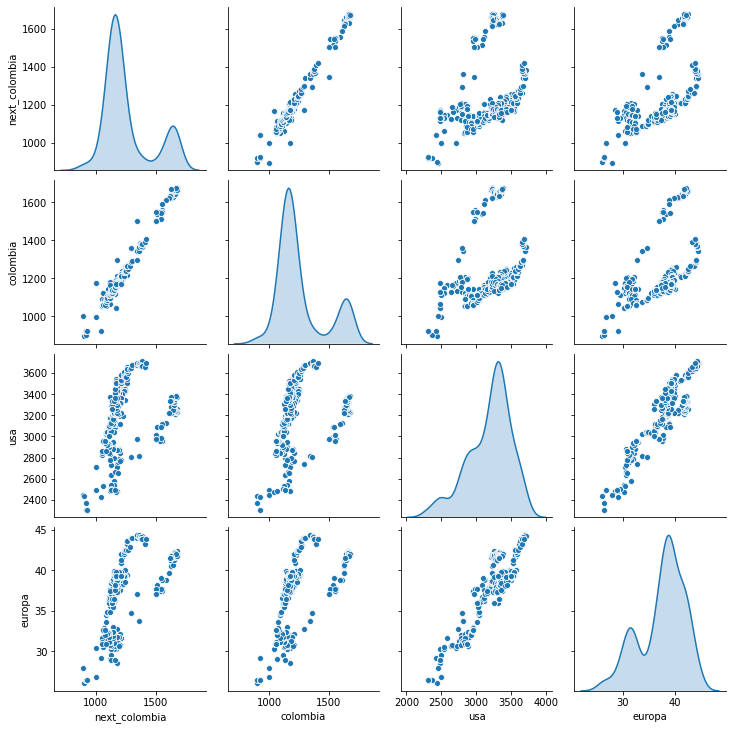

In [5]:
sns.pairplot(df_full [["next_colombia","colombia","usa", "europa"]], diag_kind="kde")

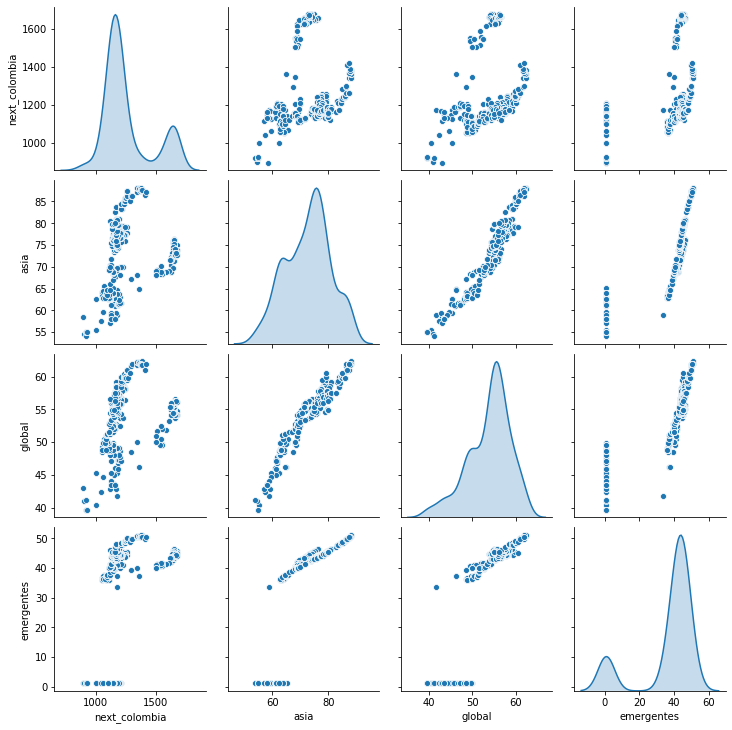

In [6]:
sns.pairplot(df_full [["next_colombia","asia","global", "emergentes"]], diag_kind="kde")

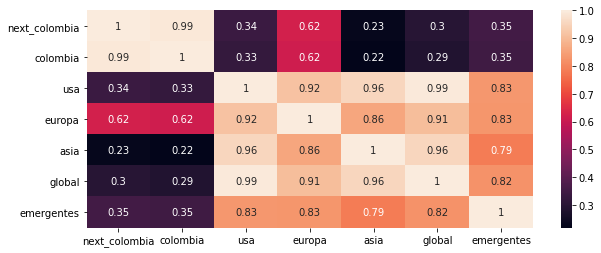

In [7]:
fig=plt.figure(figsize=(10,4))
sns.heatmap(df_full[["next_colombia","colombia","usa", "europa","asia","global", "emergentes"]].corr(), annot=True)
plt.show()

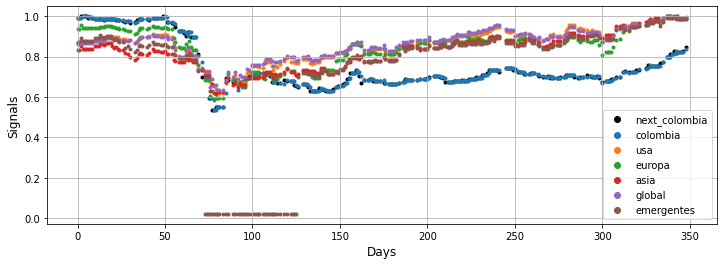

In [8]:
# Drop undesidered Columns, Split the dataset, Extract, Scale and Visualize

# Drop undesidered Columns
# To use all features keep the next lines commented
#df_full = df_full.drop(columns=['colombia','emergentes'])
#config_key = "independant"

#Trivial Configuration
#df_full = df_full.drop(columns=['emergentes'])
#config_key = "Trivial"

#Split the dataset
train_df = df_full.sample(frac=0.8,random_state=0)
test_df = df_full.drop(train_df.index)

# Extract to numpy arrays
train_data=train_df.to_numpy()
test_data=test_df.to_numpy()
train_data_shape= train_data.shape
test_data_shape= test_data.shape

# Select day (time)
train_time= train_data[:,3]
test_time= test_data[:,3]

# Select target values or labels
Y_max=train_data[:,1].max()
y_train = train_data [:,1]/Y_max
y_test = test_data[:,1]/Y_max

# Select Feautures
X_max=train_data[:,4:11].max(axis=0)
x_train= train_data[:,4:11]/X_max
x_test =test_data[:,4:11]/X_max

# Visualize target value and most correlated Feautures vs time
fig=plt.figure(figsize=(12,4))
plt.ylabel('Signals', fontsize=12)
plt.xlabel('Days', fontsize=12)
# Visualize next_colombia vs time
plt.scatter(train_time,y_train,marker=".", color="black")
# Colombia
plt.scatter(train_time,x_train[:,0],marker=".")
# usa
plt.scatter(train_time,x_train[:,1],marker=".")
# europa
plt.scatter(train_time,x_train[:,2],marker=".")
# asia
plt.scatter(train_time,x_train[:,3],marker=".")
# global
plt.scatter(train_time,x_train[:,4],marker=".")
# emergentes
plt.scatter(train_time,x_train[:,5],marker=".")

plt.legend(["next_colombia","colombia","usa", "europa","asia","global", "emergentes"],loc="lower right",markerscale=2)

plt.grid()
plt.show()

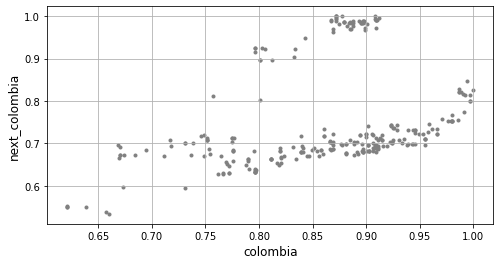

In [9]:
# Visualize next_colombia vs colombia
fig=plt.figure(figsize=(8,4))
plt.ylabel('next_colombia', fontsize=12)
plt.xlabel('colombia', fontsize=12)
plt.scatter(x_train[:,1],y_train,marker=".", color="gray")
plt.grid()
plt.show()

In [10]:
# Create and compile a neural network using Keras Sequiential method
# The architectue (number of layers, activations, etc) was esstablished after many trials

model = keras.Sequential([
    
    # First layer: 
    keras.layers.Dense(12, activation='relu', input_shape=(x_train.shape[1],)),
    
    # Middle layers
    keras.layers.Dense(6, activation='relu'),
    # Last layer: 
    keras.layers.Dense(1, activation='relu'),
])

# Compile the model, using RMSprop optimizer
model.compile(optimizer='adam', loss='mse', metrics=['mse','mae'])

# Print the model characteristics
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                84        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Train the neural network, and visualize errors,
# Define the epochs number for the run
EPOCHS=5000
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=EPOCHS, verbose=1)

Train on 279 samples, validate on 70 samples
Epoch 1/5000
279/279 [==============================] - 0s 1ms/step - loss: 0.1403 - mse: 0.1403 - mae: 0.3607 - val_loss: 0.0951 - val_mse: 0.0951 - val_mae: 0.2954
Epoch 2/5000
279/279 [==============================] - 0s 93us/step - loss: 0.0783 - mse: 0.0783 - mae: 0.2628 - val_loss: 0.0467 - val_mse: 0.0467 - val_mae: 0.1977
Epoch 3/5000
279/279 [==============================] - 0s 93us/step - loss: 0.0365 - mse: 0.0365 - mae: 0.1610 - val_loss: 0.0156 - val_mse: 0.0156 - val_mae: 0.0873
Epoch 4/5000
279/279 [==============================] - 0s 90us/step - loss: 0.0129 - mse: 0.0129 - mae: 0.0797 - val_loss: 0.0083 - val_mse: 0.0083 - val_mae: 0.0802
Epoch 5/5000
279/279 [==============================] - 0s 90us/step - loss: 0.0100 - mse: 0.0100 - mae: 0.0923 - val_loss: 0.0109 - val_mse: 0.0109 - val_mae: 0.0962
Epoch 6/5000
279/279 [==============================] - 0s 93us/step - loss: 0.0108 - mse: 0.0108 - mae: 0.0975 - val_los

279/279 [==============================] - 0s 90us/step - loss: 0.0061 - mse: 0.0061 - mae: 0.0653 - val_loss: 0.0053 - val_mse: 0.0053 - val_mae: 0.0611
Epoch 50/5000
279/279 [==============================] - 0s 90us/step - loss: 0.0060 - mse: 0.0060 - mae: 0.0656 - val_loss: 0.0052 - val_mse: 0.0052 - val_mae: 0.0607
Epoch 51/5000
279/279 [==============================] - 0s 86us/step - loss: 0.0060 - mse: 0.0060 - mae: 0.0636 - val_loss: 0.0051 - val_mse: 0.0051 - val_mae: 0.0585
Epoch 52/5000
279/279 [==============================] - 0s 90us/step - loss: 0.0059 - mse: 0.0059 - mae: 0.0638 - val_loss: 0.0051 - val_mse: 0.0051 - val_mae: 0.0605
Epoch 53/5000
279/279 [==============================] - 0s 90us/step - loss: 0.0059 - mse: 0.0059 - mae: 0.0667 - val_loss: 0.0051 - val_mse: 0.0051 - val_mae: 0.0613
Epoch 54/5000
279/279 [==============================] - 0s 90us/step - loss: 0.0058 - mse: 0.0058 - mae: 0.0629 - val_loss: 0.0049 - val_mse: 0.0049 - val_mae: 0.0564
Epoch 

Epoch 98/5000
279/279 [==============================] - 0s 90us/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0403 - val_loss: 0.0021 - val_mse: 0.0021 - val_mae: 0.0383
Epoch 99/5000
279/279 [==============================] - 0s 86us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0413 - val_loss: 0.0020 - val_mse: 0.0020 - val_mae: 0.0374
Epoch 100/5000
279/279 [==============================] - 0s 90us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0391 - val_loss: 0.0019 - val_mse: 0.0019 - val_mae: 0.0360
Epoch 101/5000
279/279 [==============================] - 0s 86us/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0379 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0348
Epoch 102/5000
279/279 [==============================] - 0s 86us/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0391 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0358
Epoch 103/5000
279/279 [==============================] - 0s 93us/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0367 - val_loss: 0.0017 - val_mse: 0.0017 - val_

279/279 [==============================] - 0s 82us/step - loss: 3.6944e-04 - mse: 3.6944e-04 - mae: 0.0143 - val_loss: 3.1066e-04 - val_mse: 3.1066e-04 - val_mae: 0.0137
Epoch 145/5000
279/279 [==============================] - 0s 90us/step - loss: 3.5558e-04 - mse: 3.5558e-04 - mae: 0.0141 - val_loss: 3.0092e-04 - val_mse: 3.0092e-04 - val_mae: 0.0132
Epoch 146/5000
279/279 [==============================] - 0s 86us/step - loss: 3.4398e-04 - mse: 3.4398e-04 - mae: 0.0134 - val_loss: 2.9292e-04 - val_mse: 2.9292e-04 - val_mae: 0.0131
Epoch 147/5000
279/279 [==============================] - 0s 90us/step - loss: 3.3430e-04 - mse: 3.3430e-04 - mae: 0.0134 - val_loss: 2.8459e-04 - val_mse: 2.8459e-04 - val_mae: 0.0126
Epoch 148/5000
279/279 [==============================] - 0s 86us/step - loss: 3.2060e-04 - mse: 3.2060e-04 - mae: 0.0129 - val_loss: 2.7896e-04 - val_mse: 2.7896e-04 - val_mae: 0.0127
Epoch 149/5000
279/279 [==============================] - 0s 86us/step - loss: 3.1723e-04 

279/279 [==============================] - 0s 82us/step - loss: 2.1557e-04 - mse: 2.1557e-04 - mae: 0.0092 - val_loss: 2.3318e-04 - val_mse: 2.3318e-04 - val_mae: 0.0101
Epoch 189/5000
279/279 [==============================] - 0s 90us/step - loss: 2.3154e-04 - mse: 2.3154e-04 - mae: 0.0096 - val_loss: 2.5453e-04 - val_mse: 2.5453e-04 - val_mae: 0.0110
Epoch 190/5000
279/279 [==============================] - 0s 90us/step - loss: 2.1251e-04 - mse: 2.1251e-04 - mae: 0.0092 - val_loss: 2.1586e-04 - val_mse: 2.1586e-04 - val_mae: 0.0091
Epoch 191/5000
279/279 [==============================] - 0s 86us/step - loss: 2.1635e-04 - mse: 2.1635e-04 - mae: 0.0089 - val_loss: 2.1205e-04 - val_mse: 2.1205e-04 - val_mae: 0.0086
Epoch 192/5000
279/279 [==============================] - 0s 86us/step - loss: 2.1129e-04 - mse: 2.1129e-04 - mae: 0.0090 - val_loss: 2.1333e-04 - val_mse: 2.1333e-04 - val_mae: 0.0089
Epoch 193/5000
279/279 [==============================] - 0s 86us/step - loss: 2.2501e-04 

279/279 [==============================] - 0s 90us/step - loss: 2.0716e-04 - mse: 2.0716e-04 - mae: 0.0084 - val_loss: 2.1842e-04 - val_mse: 2.1842e-04 - val_mae: 0.0092
Epoch 233/5000
279/279 [==============================] - 0s 90us/step - loss: 2.0460e-04 - mse: 2.0460e-04 - mae: 0.0083 - val_loss: 2.0202e-04 - val_mse: 2.0202e-04 - val_mae: 0.0080
Epoch 234/5000
279/279 [==============================] - 0s 93us/step - loss: 2.0434e-04 - mse: 2.0434e-04 - mae: 0.0084 - val_loss: 2.0185e-04 - val_mse: 2.0185e-04 - val_mae: 0.0080
Epoch 235/5000
279/279 [==============================] - 0s 86us/step - loss: 2.0654e-04 - mse: 2.0654e-04 - mae: 0.0086 - val_loss: 2.3623e-04 - val_mse: 2.3623e-04 - val_mae: 0.0105
Epoch 236/5000
279/279 [==============================] - 0s 86us/step - loss: 2.1340e-04 - mse: 2.1340e-04 - mae: 0.0089 - val_loss: 2.0295e-04 - val_mse: 2.0295e-04 - val_mae: 0.0083
Epoch 237/5000
279/279 [==============================] - 0s 90us/step - loss: 2.0204e-04 

279/279 [==============================] - 0s 86us/step - loss: 2.1042e-04 - mse: 2.1042e-04 - mae: 0.0086 - val_loss: 1.9450e-04 - val_mse: 1.9450e-04 - val_mae: 0.0076
Epoch 277/5000
279/279 [==============================] - 0s 90us/step - loss: 2.0672e-04 - mse: 2.0672e-04 - mae: 0.0086 - val_loss: 2.1621e-04 - val_mse: 2.1621e-04 - val_mae: 0.0095
Epoch 278/5000
279/279 [==============================] - 0s 83us/step - loss: 1.9989e-04 - mse: 1.9989e-04 - mae: 0.0081 - val_loss: 1.9627e-04 - val_mse: 1.9627e-04 - val_mae: 0.0079
Epoch 279/5000
279/279 [==============================] - 0s 93us/step - loss: 2.0017e-04 - mse: 2.0017e-04 - mae: 0.0083 - val_loss: 2.0126e-04 - val_mse: 2.0126e-04 - val_mae: 0.0086
Epoch 280/5000
279/279 [==============================] - 0s 90us/step - loss: 2.1425e-04 - mse: 2.1425e-04 - mae: 0.0088 - val_loss: 2.1838e-04 - val_mse: 2.1838e-04 - val_mae: 0.0097
Epoch 281/5000
279/279 [==============================] - 0s 82us/step - loss: 2.0730e-04 

279/279 [==============================] - 0s 93us/step - loss: 1.9259e-04 - mse: 1.9259e-04 - mae: 0.0077 - val_loss: 1.8911e-04 - val_mse: 1.8911e-04 - val_mae: 0.0075
Epoch 321/5000
279/279 [==============================] - 0s 86us/step - loss: 1.9483e-04 - mse: 1.9483e-04 - mae: 0.0078 - val_loss: 1.9197e-04 - val_mse: 1.9197e-04 - val_mae: 0.0078
Epoch 322/5000
279/279 [==============================] - ETA: 0s - loss: 6.3962e-05 - mse: 6.3962e-05 - mae: 0.005 - 0s 90us/step - loss: 1.9233e-04 - mse: 1.9233e-04 - mae: 0.0077 - val_loss: 1.9885e-04 - val_mse: 1.9885e-04 - val_mae: 0.0084
Epoch 323/5000
279/279 [==============================] - 0s 97us/step - loss: 2.0143e-04 - mse: 2.0143e-04 - mae: 0.0080 - val_loss: 1.9057e-04 - val_mse: 1.9057e-04 - val_mae: 0.0076
Epoch 324/5000
279/279 [==============================] - 0s 82us/step - loss: 1.9400e-04 - mse: 1.9400e-04 - mae: 0.0078 - val_loss: 1.9049e-04 - val_mse: 1.9049e-04 - val_mae: 0.0077
Epoch 325/5000
279/279 [======

279/279 [==============================] - 0s 86us/step - loss: 1.9631e-04 - mse: 1.9631e-04 - mae: 0.0078 - val_loss: 1.8678e-04 - val_mse: 1.8678e-04 - val_mae: 0.0074
Epoch 365/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9837e-04 - mse: 1.9837e-04 - mae: 0.0079 - val_loss: 1.8979e-04 - val_mse: 1.8979e-04 - val_mae: 0.0078
Epoch 366/5000
279/279 [==============================] - 0s 86us/step - loss: 1.9790e-04 - mse: 1.9790e-04 - mae: 0.0084 - val_loss: 1.9793e-04 - val_mse: 1.9793e-04 - val_mae: 0.0085
Epoch 367/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9113e-04 - mse: 1.9113e-04 - mae: 0.0075 - val_loss: 1.8907e-04 - val_mse: 1.8907e-04 - val_mae: 0.0077
Epoch 368/5000
279/279 [==============================] - 0s 86us/step - loss: 1.9169e-04 - mse: 1.9169e-04 - mae: 0.0075 - val_loss: 1.9167e-04 - val_mse: 1.9167e-04 - val_mae: 0.0079
Epoch 369/5000
279/279 [==============================] - 0s 86us/step - loss: 1.9142e-04 

279/279 [==============================] - 0s 86us/step - loss: 1.9153e-04 - mse: 1.9153e-04 - mae: 0.0078 - val_loss: 1.9148e-04 - val_mse: 1.9148e-04 - val_mae: 0.0081
Epoch 409/5000
279/279 [==============================] - 0s 93us/step - loss: 1.9280e-04 - mse: 1.9280e-04 - mae: 0.0076 - val_loss: 1.8621e-04 - val_mse: 1.8621e-04 - val_mae: 0.0075
Epoch 410/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9242e-04 - mse: 1.9242e-04 - mae: 0.0076 - val_loss: 2.0398e-04 - val_mse: 2.0398e-04 - val_mae: 0.0091
Epoch 411/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9275e-04 - mse: 1.9275e-04 - mae: 0.0075 - val_loss: 1.9735e-04 - val_mse: 1.9735e-04 - val_mae: 0.0085
Epoch 412/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9356e-04 - mse: 1.9356e-04 - mae: 0.0076 - val_loss: 1.9680e-04 - val_mse: 1.9680e-04 - val_mae: 0.0085
Epoch 413/5000
279/279 [==============================] - 0s 82us/step - loss: 1.9286e-04 

279/279 [==============================] - 0s 82us/step - loss: 1.8837e-04 - mse: 1.8837e-04 - mae: 0.0073 - val_loss: 1.8655e-04 - val_mse: 1.8655e-04 - val_mae: 0.0077
Epoch 453/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8865e-04 - mse: 1.8865e-04 - mae: 0.0073 - val_loss: 1.8536e-04 - val_mse: 1.8536e-04 - val_mae: 0.0076
Epoch 454/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8981e-04 - mse: 1.8981e-04 - mae: 0.0074 - val_loss: 1.8218e-04 - val_mse: 1.8218e-04 - val_mae: 0.0073
Epoch 455/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9089e-04 - mse: 1.9089e-04 - mae: 0.0075 - val_loss: 1.8234e-04 - val_mse: 1.8234e-04 - val_mae: 0.0073
Epoch 456/5000
279/279 [==============================] - 0s 86us/step - loss: 2.1127e-04 - mse: 2.1127e-04 - mae: 0.0088 - val_loss: 1.9568e-04 - val_mse: 1.9568e-04 - val_mae: 0.0086
Epoch 457/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8470e-04 

279/279 [==============================] - 0s 90us/step - loss: 1.9909e-04 - mse: 1.9909e-04 - mae: 0.0082 - val_loss: 1.8059e-04 - val_mse: 1.8059e-04 - val_mae: 0.0073
Epoch 497/5000
279/279 [==============================] - 0s 90us/step - loss: 2.1291e-04 - mse: 2.1291e-04 - mae: 0.0090 - val_loss: 1.9523e-04 - val_mse: 1.9523e-04 - val_mae: 0.0086
Epoch 498/5000
279/279 [==============================] - 0s 86us/step - loss: 2.2179e-04 - mse: 2.2179e-04 - mae: 0.0092 - val_loss: 1.9121e-04 - val_mse: 1.9121e-04 - val_mae: 0.0082
Epoch 499/5000
279/279 [==============================] - 0s 90us/step - loss: 2.1896e-04 - mse: 2.1896e-04 - mae: 0.0089 - val_loss: 1.8056e-04 - val_mse: 1.8056e-04 - val_mae: 0.0072
Epoch 500/5000
279/279 [==============================] - 0s 82us/step - loss: 1.9118e-04 - mse: 1.9118e-04 - mae: 0.0074 - val_loss: 1.8270e-04 - val_mse: 1.8270e-04 - val_mae: 0.0075
Epoch 501/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8767e-04 

279/279 [==============================] - 0s 86us/step - loss: 2.3894e-04 - mse: 2.3894e-04 - mae: 0.0102 - val_loss: 2.0036e-04 - val_mse: 2.0036e-04 - val_mae: 0.0089
Epoch 541/5000
279/279 [==============================] - 0s 86us/step - loss: 2.0627e-04 - mse: 2.0627e-04 - mae: 0.0088 - val_loss: 2.3563e-04 - val_mse: 2.3563e-04 - val_mae: 0.0109
Epoch 542/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8809e-04 - mse: 1.8809e-04 - mae: 0.0077 - val_loss: 1.9262e-04 - val_mse: 1.9262e-04 - val_mae: 0.0084
Epoch 543/5000
279/279 [==============================] - 0s 86us/step - loss: 1.9786e-04 - mse: 1.9786e-04 - mae: 0.0078 - val_loss: 1.9903e-04 - val_mse: 1.9903e-04 - val_mae: 0.0088
Epoch 544/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9660e-04 - mse: 1.9660e-04 - mae: 0.0077 - val_loss: 1.8251e-04 - val_mse: 1.8251e-04 - val_mae: 0.0076
Epoch 545/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9309e-04 

279/279 [==============================] - 0s 86us/step - loss: 1.9342e-04 - mse: 1.9342e-04 - mae: 0.0076 - val_loss: 1.7920e-04 - val_mse: 1.7920e-04 - val_mae: 0.0072
Epoch 585/5000
279/279 [==============================] - 0s 93us/step - loss: 1.9089e-04 - mse: 1.9089e-04 - mae: 0.0075 - val_loss: 1.7834e-04 - val_mse: 1.7834e-04 - val_mae: 0.0072
Epoch 586/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8760e-04 - mse: 1.8760e-04 - mae: 0.0073 - val_loss: 1.7827e-04 - val_mse: 1.7827e-04 - val_mae: 0.0072
Epoch 587/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8826e-04 - mse: 1.8826e-04 - mae: 0.0075 - val_loss: 1.7942e-04 - val_mse: 1.7942e-04 - val_mae: 0.0073
Epoch 588/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8735e-04 - mse: 1.8735e-04 - mae: 0.0073 - val_loss: 1.7880e-04 - val_mse: 1.7880e-04 - val_mae: 0.0072
Epoch 589/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8873e-04 

279/279 [==============================] - 0s 86us/step - loss: 2.1943e-04 - mse: 2.1943e-04 - mae: 0.0092 - val_loss: 1.8839e-04 - val_mse: 1.8839e-04 - val_mae: 0.0082
Epoch 629/5000
279/279 [==============================] - 0s 90us/step - loss: 2.1488e-04 - mse: 2.1488e-04 - mae: 0.0088 - val_loss: 1.7748e-04 - val_mse: 1.7748e-04 - val_mae: 0.0072
Epoch 630/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8407e-04 - mse: 1.8407e-04 - mae: 0.0072 - val_loss: 1.8712e-04 - val_mse: 1.8712e-04 - val_mae: 0.0081
Epoch 631/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9406e-04 - mse: 1.9406e-04 - mae: 0.0077 - val_loss: 1.7711e-04 - val_mse: 1.7711e-04 - val_mae: 0.0072
Epoch 632/5000
279/279 [==============================] - 0s 93us/step - loss: 1.8431e-04 - mse: 1.8431e-04 - mae: 0.0072 - val_loss: 2.2444e-04 - val_mse: 2.2444e-04 - val_mae: 0.0104
Epoch 633/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9801e-04 

279/279 [==============================] - 0s 86us/step - loss: 1.9330e-04 - mse: 1.9330e-04 - mae: 0.0078 - val_loss: 1.8120e-04 - val_mse: 1.8120e-04 - val_mae: 0.0076
Epoch 673/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8560e-04 - mse: 1.8560e-04 - mae: 0.0074 - val_loss: 1.7817e-04 - val_mse: 1.7817e-04 - val_mae: 0.0073
Epoch 674/5000
279/279 [==============================] - 0s 93us/step - loss: 1.8364e-04 - mse: 1.8364e-04 - mae: 0.0074 - val_loss: 1.8144e-04 - val_mse: 1.8144e-04 - val_mae: 0.0076
Epoch 675/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8458e-04 - mse: 1.8458e-04 - mae: 0.0075 - val_loss: 1.9022e-04 - val_mse: 1.9022e-04 - val_mae: 0.0084
Epoch 676/5000
279/279 [==============================] - 0s 86us/step - loss: 1.9693e-04 - mse: 1.9693e-04 - mae: 0.0082 - val_loss: 1.8998e-04 - val_mse: 1.8998e-04 - val_mae: 0.0084
Epoch 677/5000
279/279 [==============================] - 0s 93us/step - loss: 1.8728e-04 

279/279 [==============================] - 0s 90us/step - loss: 1.9398e-04 - mse: 1.9398e-04 - mae: 0.0082 - val_loss: 1.7677e-04 - val_mse: 1.7677e-04 - val_mae: 0.0072
Epoch 717/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8175e-04 - mse: 1.8175e-04 - mae: 0.0071 - val_loss: 1.8198e-04 - val_mse: 1.8198e-04 - val_mae: 0.0079
Epoch 718/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8615e-04 - mse: 1.8615e-04 - mae: 0.0073 - val_loss: 1.7934e-04 - val_mse: 1.7934e-04 - val_mae: 0.0075
Epoch 719/5000
279/279 [==============================] - 0s 86us/step - loss: 2.0960e-04 - mse: 2.0960e-04 - mae: 0.0083 - val_loss: 1.7971e-04 - val_mse: 1.7971e-04 - val_mae: 0.0075
Epoch 720/5000
279/279 [==============================] - 0s 86us/step - loss: 2.1108e-04 - mse: 2.1108e-04 - mae: 0.0091 - val_loss: 1.7674e-04 - val_mse: 1.7674e-04 - val_mae: 0.0072
Epoch 721/5000
279/279 [==============================] - 0s 93us/step - loss: 2.4644e-04 

279/279 [==============================] - 0s 90us/step - loss: 1.8442e-04 - mse: 1.8442e-04 - mae: 0.0072 - val_loss: 1.7525e-04 - val_mse: 1.7525e-04 - val_mae: 0.0072
Epoch 761/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8575e-04 - mse: 1.8575e-04 - mae: 0.0076 - val_loss: 1.7972e-04 - val_mse: 1.7972e-04 - val_mae: 0.0077
Epoch 762/5000
279/279 [==============================] - 0s 82us/step - loss: 1.9283e-04 - mse: 1.9283e-04 - mae: 0.0080 - val_loss: 1.7522e-04 - val_mse: 1.7522e-04 - val_mae: 0.0072
Epoch 763/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8888e-04 - mse: 1.8888e-04 - mae: 0.0074 - val_loss: 1.7674e-04 - val_mse: 1.7674e-04 - val_mae: 0.0073
Epoch 764/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8855e-04 - mse: 1.8855e-04 - mae: 0.0075 - val_loss: 1.7723e-04 - val_mse: 1.7723e-04 - val_mae: 0.0074
Epoch 765/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8025e-04 

279/279 [==============================] - 0s 104us/step - loss: 2.0831e-04 - mse: 2.0831e-04 - mae: 0.0086 - val_loss: 1.8997e-04 - val_mse: 1.8997e-04 - val_mae: 0.0086
Epoch 805/5000
279/279 [==============================] - 0s 86us/step - loss: 1.9521e-04 - mse: 1.9521e-04 - mae: 0.0077 - val_loss: 1.7489e-04 - val_mse: 1.7489e-04 - val_mae: 0.0072
Epoch 806/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8261e-04 - mse: 1.8261e-04 - mae: 0.0072 - val_loss: 1.7626e-04 - val_mse: 1.7626e-04 - val_mae: 0.0074
Epoch 807/5000
279/279 [==============================] - 0s 93us/step - loss: 1.9414e-04 - mse: 1.9414e-04 - mae: 0.0077 - val_loss: 1.7517e-04 - val_mse: 1.7517e-04 - val_mae: 0.0073
Epoch 808/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8553e-04 - mse: 1.8553e-04 - mae: 0.0075 - val_loss: 1.7448e-04 - val_mse: 1.7448e-04 - val_mae: 0.0071
Epoch 809/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9601e-04

279/279 [==============================] - 0s 82us/step - loss: 1.8080e-04 - mse: 1.8080e-04 - mae: 0.0071 - val_loss: 2.3987e-04 - val_mse: 2.3987e-04 - val_mae: 0.0113
Epoch 849/5000
279/279 [==============================] - 0s 90us/step - loss: 2.2613e-04 - mse: 2.2613e-04 - mae: 0.0096 - val_loss: 2.3772e-04 - val_mse: 2.3772e-04 - val_mae: 0.0112
Epoch 850/5000
279/279 [==============================] - 0s 86us/step - loss: 1.9979e-04 - mse: 1.9979e-04 - mae: 0.0082 - val_loss: 1.8623e-04 - val_mse: 1.8623e-04 - val_mae: 0.0082
Epoch 851/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8046e-04 - mse: 1.8046e-04 - mae: 0.0070 - val_loss: 1.7454e-04 - val_mse: 1.7454e-04 - val_mae: 0.0073
Epoch 852/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8501e-04 - mse: 1.8501e-04 - mae: 0.0075 - val_loss: 1.7519e-04 - val_mse: 1.7519e-04 - val_mae: 0.0073
Epoch 853/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9810e-04 

279/279 [==============================] - 0s 90us/step - loss: 1.8042e-04 - mse: 1.8042e-04 - mae: 0.0070 - val_loss: 1.9544e-04 - val_mse: 1.9544e-04 - val_mae: 0.0088
Epoch 893/5000
279/279 [==============================] - 0s 93us/step - loss: 1.8706e-04 - mse: 1.8706e-04 - mae: 0.0076 - val_loss: 1.7498e-04 - val_mse: 1.7498e-04 - val_mae: 0.0072
Epoch 894/5000
279/279 [==============================] - 0s 82us/step - loss: 1.8746e-04 - mse: 1.8746e-04 - mae: 0.0073 - val_loss: 1.7420e-04 - val_mse: 1.7420e-04 - val_mae: 0.0072
Epoch 895/5000
279/279 [==============================] - 0s 93us/step - loss: 1.9758e-04 - mse: 1.9758e-04 - mae: 0.0083 - val_loss: 1.7758e-04 - val_mse: 1.7758e-04 - val_mae: 0.0075
Epoch 896/5000
279/279 [==============================] - 0s 93us/step - loss: 2.0708e-04 - mse: 2.0708e-04 - mae: 0.0087 - val_loss: 1.7337e-04 - val_mse: 1.7337e-04 - val_mae: 0.0071
Epoch 897/5000
279/279 [==============================] - 0s 93us/step - loss: 1.9268e-04 

279/279 [==============================] - 0s 86us/step - loss: 1.8728e-04 - mse: 1.8728e-04 - mae: 0.0075 - val_loss: 1.7292e-04 - val_mse: 1.7292e-04 - val_mae: 0.0072
Epoch 937/5000
279/279 [==============================] - 0s 93us/step - loss: 1.8189e-04 - mse: 1.8189e-04 - mae: 0.0071 - val_loss: 1.8451e-04 - val_mse: 1.8451e-04 - val_mae: 0.0082
Epoch 938/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8757e-04 - mse: 1.8757e-04 - mae: 0.0076 - val_loss: 1.8497e-04 - val_mse: 1.8497e-04 - val_mae: 0.0083
Epoch 939/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8677e-04 - mse: 1.8677e-04 - mae: 0.0076 - val_loss: 1.7364e-04 - val_mse: 1.7364e-04 - val_mae: 0.0072
Epoch 940/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8031e-04 - mse: 1.8031e-04 - mae: 0.0071 - val_loss: 2.0797e-04 - val_mse: 2.0797e-04 - val_mae: 0.0097
Epoch 941/5000
279/279 [==============================] - 0s 86us/step - loss: 1.9759e-04 

279/279 [==============================] - 0s 86us/step - loss: 1.8396e-04 - mse: 1.8396e-04 - mae: 0.0074 - val_loss: 1.8683e-04 - val_mse: 1.8683e-04 - val_mae: 0.0083
Epoch 981/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8800e-04 - mse: 1.8800e-04 - mae: 0.0075 - val_loss: 2.2575e-04 - val_mse: 2.2575e-04 - val_mae: 0.0106
Epoch 982/5000
279/279 [==============================] - 0s 93us/step - loss: 2.0587e-04 - mse: 2.0587e-04 - mae: 0.0084 - val_loss: 2.1471e-04 - val_mse: 2.1471e-04 - val_mae: 0.0100
Epoch 983/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8825e-04 - mse: 1.8825e-04 - mae: 0.0077 - val_loss: 2.2014e-04 - val_mse: 2.2014e-04 - val_mae: 0.0103
Epoch 984/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9115e-04 - mse: 1.9115e-04 - mae: 0.0079 - val_loss: 2.7064e-04 - val_mse: 2.7064e-04 - val_mae: 0.0126
Epoch 985/5000
279/279 [==============================] - 0s 86us/step - loss: 2.2918e-04 

279/279 [==============================] - 0s 90us/step - loss: 1.8591e-04 - mse: 1.8591e-04 - mae: 0.0077 - val_loss: 1.7825e-04 - val_mse: 1.7825e-04 - val_mae: 0.0078
Epoch 1025/5000
279/279 [==============================] - 0s 97us/step - loss: 1.8268e-04 - mse: 1.8268e-04 - mae: 0.0075 - val_loss: 1.7216e-04 - val_mse: 1.7216e-04 - val_mae: 0.0071
Epoch 1026/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7757e-04 - mse: 1.7757e-04 - mae: 0.0069 - val_loss: 1.9107e-04 - val_mse: 1.9107e-04 - val_mae: 0.0087
Epoch 1027/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8069e-04 - mse: 1.8069e-04 - mae: 0.0071 - val_loss: 1.7677e-04 - val_mse: 1.7677e-04 - val_mae: 0.0076
Epoch 1028/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8071e-04 - mse: 1.8071e-04 - mae: 0.0073 - val_loss: 1.7219e-04 - val_mse: 1.7219e-04 - val_mae: 0.0072
Epoch 1029/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7693

279/279 [==============================] - 0s 86us/step - loss: 1.8247e-04 - mse: 1.8247e-04 - mae: 0.0075 - val_loss: 2.0996e-04 - val_mse: 2.0996e-04 - val_mae: 0.0098
Epoch 1069/5000
279/279 [==============================] - 0s 86us/step - loss: 1.9934e-04 - mse: 1.9934e-04 - mae: 0.0081 - val_loss: 1.7507e-04 - val_mse: 1.7507e-04 - val_mae: 0.0075
Epoch 1070/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9547e-04 - mse: 1.9547e-04 - mae: 0.0084 - val_loss: 1.7413e-04 - val_mse: 1.7413e-04 - val_mae: 0.0074
Epoch 1071/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7381e-04 - mse: 1.7381e-04 - mae: 0.0073 - val_loss: 2.8348e-04 - val_mse: 2.8348e-04 - val_mae: 0.0131
Epoch 1072/5000
279/279 [==============================] - 0s 90us/step - loss: 2.3405e-04 - mse: 2.3405e-04 - mae: 0.0101 - val_loss: 3.0553e-04 - val_mse: 3.0553e-04 - val_mae: 0.0139
Epoch 1073/5000
279/279 [==============================] - 0s 86us/step - loss: 2.4584

279/279 [==============================] - 0s 93us/step - loss: 1.9580e-04 - mse: 1.9580e-04 - mae: 0.0078 - val_loss: 1.7819e-04 - val_mse: 1.7819e-04 - val_mae: 0.0078
Epoch 1113/5000
279/279 [==============================] - 0s 97us/step - loss: 1.8855e-04 - mse: 1.8855e-04 - mae: 0.0078 - val_loss: 1.7837e-04 - val_mse: 1.7837e-04 - val_mae: 0.0078
Epoch 1114/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8606e-04 - mse: 1.8606e-04 - mae: 0.0073 - val_loss: 1.7805e-04 - val_mse: 1.7805e-04 - val_mae: 0.0078
Epoch 1115/5000
279/279 [==============================] - 0s 90us/step - loss: 2.0246e-04 - mse: 2.0246e-04 - mae: 0.0089 - val_loss: 1.7191e-04 - val_mse: 1.7191e-04 - val_mae: 0.0072
Epoch 1116/5000
279/279 [==============================] - 0s 90us/step - loss: 2.0865e-04 - mse: 2.0865e-04 - mae: 0.0084 - val_loss: 2.0126e-04 - val_mse: 2.0126e-04 - val_mae: 0.0093
Epoch 1117/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8546

279/279 [==============================] - 0s 83us/step - loss: 1.9417e-04 - mse: 1.9417e-04 - mae: 0.0077 - val_loss: 1.8600e-04 - val_mse: 1.8600e-04 - val_mae: 0.0084
Epoch 1157/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7759e-04 - mse: 1.7759e-04 - mae: 0.0071 - val_loss: 1.7104e-04 - val_mse: 1.7104e-04 - val_mae: 0.0071
Epoch 1158/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7939e-04 - mse: 1.7939e-04 - mae: 0.0070 - val_loss: 1.7279e-04 - val_mse: 1.7279e-04 - val_mae: 0.0073
Epoch 1159/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8801e-04 - mse: 1.8801e-04 - mae: 0.0078 - val_loss: 1.7194e-04 - val_mse: 1.7194e-04 - val_mae: 0.0073
Epoch 1160/5000
279/279 [==============================] - 0s 89us/step - loss: 1.8311e-04 - mse: 1.8311e-04 - mae: 0.0072 - val_loss: 1.7433e-04 - val_mse: 1.7433e-04 - val_mae: 0.0075
Epoch 1161/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7873

279/279 [==============================] - 0s 86us/step - loss: 1.8467e-04 - mse: 1.8467e-04 - mae: 0.0079 - val_loss: 1.7931e-04 - val_mse: 1.7931e-04 - val_mae: 0.0080
Epoch 1201/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8879e-04 - mse: 1.8879e-04 - mae: 0.0078 - val_loss: 1.7018e-04 - val_mse: 1.7018e-04 - val_mae: 0.0071
Epoch 1202/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7717e-04 - mse: 1.7717e-04 - mae: 0.0069 - val_loss: 1.7047e-04 - val_mse: 1.7047e-04 - val_mae: 0.0072
Epoch 1203/5000
279/279 [==============================] - 0s 97us/step - loss: 1.8207e-04 - mse: 1.8207e-04 - mae: 0.0072 - val_loss: 1.7189e-04 - val_mse: 1.7189e-04 - val_mae: 0.0074
Epoch 1204/5000
279/279 [==============================] - 0s 93us/step - loss: 1.9102e-04 - mse: 1.9102e-04 - mae: 0.0075 - val_loss: 1.9123e-04 - val_mse: 1.9123e-04 - val_mae: 0.0087
Epoch 1205/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9664

279/279 [==============================] - 0s 93us/step - loss: 1.7803e-04 - mse: 1.7803e-04 - mae: 0.0068 - val_loss: 1.7203e-04 - val_mse: 1.7203e-04 - val_mae: 0.0074
Epoch 1245/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8189e-04 - mse: 1.8189e-04 - mae: 0.0071 - val_loss: 1.8177e-04 - val_mse: 1.8177e-04 - val_mae: 0.0082
Epoch 1246/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7883e-04 - mse: 1.7883e-04 - mae: 0.0069 - val_loss: 1.8650e-04 - val_mse: 1.8650e-04 - val_mae: 0.0085
Epoch 1247/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7962e-04 - mse: 1.7962e-04 - mae: 0.0071 - val_loss: 1.7162e-04 - val_mse: 1.7162e-04 - val_mae: 0.0073
Epoch 1248/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8977e-04 - mse: 1.8977e-04 - mae: 0.0075 - val_loss: 2.1331e-04 - val_mse: 2.1331e-04 - val_mae: 0.0101
Epoch 1249/5000
279/279 [==============================] - 0s 93us/step - loss: 1.9804

279/279 [==============================] - 0s 86us/step - loss: 1.7804e-04 - mse: 1.7804e-04 - mae: 0.0075 - val_loss: 1.6976e-04 - val_mse: 1.6976e-04 - val_mae: 0.0071
Epoch 1289/5000
279/279 [==============================] - 0s 93us/step - loss: 1.8385e-04 - mse: 1.8385e-04 - mae: 0.0072 - val_loss: 1.7260e-04 - val_mse: 1.7260e-04 - val_mae: 0.0075
Epoch 1290/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9895e-04 - mse: 1.9895e-04 - mae: 0.0082 - val_loss: 1.6856e-04 - val_mse: 1.6856e-04 - val_mae: 0.0070
Epoch 1291/5000
279/279 [==============================] - 0s 86us/step - loss: 1.9543e-04 - mse: 1.9543e-04 - mae: 0.0078 - val_loss: 1.9530e-04 - val_mse: 1.9530e-04 - val_mae: 0.0091
Epoch 1292/5000
279/279 [==============================] - 0s 90us/step - loss: 2.0171e-04 - mse: 2.0171e-04 - mae: 0.0092 - val_loss: 2.0262e-04 - val_mse: 2.0262e-04 - val_mae: 0.0095
Epoch 1293/5000
279/279 [==============================] - 0s 86us/step - loss: 2.2295

279/279 [==============================] - 0s 93us/step - loss: 2.1317e-04 - mse: 2.1317e-04 - mae: 0.0088 - val_loss: 2.6524e-04 - val_mse: 2.6524e-04 - val_mae: 0.0125
Epoch 1333/5000
279/279 [==============================] - 0s 90us/step - loss: 2.0016e-04 - mse: 2.0016e-04 - mae: 0.0087 - val_loss: 2.1050e-04 - val_mse: 2.1050e-04 - val_mae: 0.0100
Epoch 1334/5000
279/279 [==============================] - 0s 90us/step - loss: 2.0770e-04 - mse: 2.0770e-04 - mae: 0.0087 - val_loss: 1.9925e-04 - val_mse: 1.9925e-04 - val_mae: 0.0093
Epoch 1335/5000
279/279 [==============================] - 0s 86us/step - loss: 2.1927e-04 - mse: 2.1927e-04 - mae: 0.0097 - val_loss: 2.3771e-04 - val_mse: 2.3771e-04 - val_mae: 0.0113
Epoch 1336/5000
279/279 [==============================] - 0s 90us/step - loss: 2.0932e-04 - mse: 2.0932e-04 - mae: 0.0089 - val_loss: 2.1037e-04 - val_mse: 2.1037e-04 - val_mae: 0.0099
Epoch 1337/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8273

279/279 [==============================] - 0s 86us/step - loss: 1.8249e-04 - mse: 1.8249e-04 - mae: 0.0072 - val_loss: 1.7613e-04 - val_mse: 1.7613e-04 - val_mae: 0.0078
Epoch 1377/5000
279/279 [==============================] - 0s 93us/step - loss: 2.0693e-04 - mse: 2.0693e-04 - mae: 0.0086 - val_loss: 2.3333e-04 - val_mse: 2.3333e-04 - val_mae: 0.0114
Epoch 1378/5000
279/279 [==============================] - 0s 90us/step - loss: 2.2062e-04 - mse: 2.2062e-04 - mae: 0.0096 - val_loss: 2.2562e-04 - val_mse: 2.2562e-04 - val_mae: 0.0109
Epoch 1379/5000
279/279 [==============================] - 0s 90us/step - loss: 2.0732e-04 - mse: 2.0732e-04 - mae: 0.0084 - val_loss: 1.6891e-04 - val_mse: 1.6891e-04 - val_mae: 0.0070
Epoch 1380/5000
279/279 [==============================] - 0s 100us/step - loss: 1.7836e-04 - mse: 1.7836e-04 - mae: 0.0072 - val_loss: 1.6910e-04 - val_mse: 1.6910e-04 - val_mae: 0.0070
Epoch 1381/5000
279/279 [==============================] - 0s 86us/step - loss: 1.796

279/279 [==============================] - 0s 93us/step - loss: 1.7473e-04 - mse: 1.7473e-04 - mae: 0.0070 - val_loss: 1.8183e-04 - val_mse: 1.8183e-04 - val_mae: 0.0082
Epoch 1421/5000
279/279 [==============================] - 0s 97us/step - loss: 1.7553e-04 - mse: 1.7553e-04 - mae: 0.0069 - val_loss: 1.8377e-04 - val_mse: 1.8377e-04 - val_mae: 0.0083
Epoch 1422/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8027e-04 - mse: 1.8027e-04 - mae: 0.0071 - val_loss: 1.7519e-04 - val_mse: 1.7519e-04 - val_mae: 0.0077
Epoch 1423/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7796e-04 - mse: 1.7796e-04 - mae: 0.0070 - val_loss: 1.6946e-04 - val_mse: 1.6946e-04 - val_mae: 0.0073
Epoch 1424/5000
279/279 [==============================] - 0s 93us/step - loss: 1.8627e-04 - mse: 1.8627e-04 - mae: 0.0074 - val_loss: 1.6985e-04 - val_mse: 1.6985e-04 - val_mae: 0.0073
Epoch 1425/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9219

279/279 [==============================] - 0s 93us/step - loss: 1.8348e-04 - mse: 1.8348e-04 - mae: 0.0073 - val_loss: 1.9663e-04 - val_mse: 1.9663e-04 - val_mae: 0.0092
Epoch 1465/5000
279/279 [==============================] - 0s 93us/step - loss: 1.9742e-04 - mse: 1.9742e-04 - mae: 0.0082 - val_loss: 2.0873e-04 - val_mse: 2.0873e-04 - val_mae: 0.0099
Epoch 1466/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8981e-04 - mse: 1.8981e-04 - mae: 0.0083 - val_loss: 2.3732e-04 - val_mse: 2.3732e-04 - val_mae: 0.0114
Epoch 1467/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8820e-04 - mse: 1.8820e-04 - mae: 0.0075 - val_loss: 1.6961e-04 - val_mse: 1.6961e-04 - val_mae: 0.0073
Epoch 1468/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7912e-04 - mse: 1.7912e-04 - mae: 0.0071 - val_loss: 1.7445e-04 - val_mse: 1.7445e-04 - val_mae: 0.0077
Epoch 1469/5000
279/279 [==============================] - 0s 93us/step - loss: 1.8086

279/279 [==============================] - 0s 93us/step - loss: 1.7694e-04 - mse: 1.7694e-04 - mae: 0.0070 - val_loss: 1.6824e-04 - val_mse: 1.6824e-04 - val_mae: 0.0070
Epoch 1509/5000
279/279 [==============================] - 0s 93us/step - loss: 1.8354e-04 - mse: 1.8354e-04 - mae: 0.0073 - val_loss: 1.7637e-04 - val_mse: 1.7637e-04 - val_mae: 0.0078
Epoch 1510/5000
279/279 [==============================] - 0s 90us/step - loss: 2.0795e-04 - mse: 2.0795e-04 - mae: 0.0086 - val_loss: 1.6889e-04 - val_mse: 1.6889e-04 - val_mae: 0.0071
Epoch 1511/5000
279/279 [==============================] - 0s 100us/step - loss: 2.0986e-04 - mse: 2.0986e-04 - mae: 0.0092 - val_loss: 1.6891e-04 - val_mse: 1.6891e-04 - val_mae: 0.0072
Epoch 1512/5000
279/279 [==============================] - 0s 93us/step - loss: 1.8757e-04 - mse: 1.8757e-04 - mae: 0.0075 - val_loss: 1.7526e-04 - val_mse: 1.7526e-04 - val_mae: 0.0078
Epoch 1513/5000
279/279 [==============================] - 0s 93us/step - loss: 1.803

279/279 [==============================] - 0s 97us/step - loss: 1.9210e-04 - mse: 1.9210e-04 - mae: 0.0082 - val_loss: 1.7041e-04 - val_mse: 1.7041e-04 - val_mae: 0.0073
Epoch 1553/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7500e-04 - mse: 1.7500e-04 - mae: 0.0069 - val_loss: 1.6637e-04 - val_mse: 1.6637e-04 - val_mae: 0.0069
Epoch 1554/5000
279/279 [==============================] - 0s 82us/step - loss: 1.8269e-04 - mse: 1.8269e-04 - mae: 0.0071 - val_loss: 1.9779e-04 - val_mse: 1.9779e-04 - val_mae: 0.0092
Epoch 1555/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9280e-04 - mse: 1.9280e-04 - mae: 0.0079 - val_loss: 2.1028e-04 - val_mse: 2.1028e-04 - val_mae: 0.0100
Epoch 1556/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8198e-04 - mse: 1.8198e-04 - mae: 0.0075 - val_loss: 1.6924e-04 - val_mse: 1.6924e-04 - val_mae: 0.0073
Epoch 1557/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7196

279/279 [==============================] - 0s 90us/step - loss: 1.8065e-04 - mse: 1.8065e-04 - mae: 0.0073 - val_loss: 1.8248e-04 - val_mse: 1.8248e-04 - val_mae: 0.0085
Epoch 1597/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7755e-04 - mse: 1.7755e-04 - mae: 0.0072 - val_loss: 1.6579e-04 - val_mse: 1.6579e-04 - val_mae: 0.0069
Epoch 1598/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7596e-04 - mse: 1.7596e-04 - mae: 0.0068 - val_loss: 1.8000e-04 - val_mse: 1.8000e-04 - val_mae: 0.0081
Epoch 1599/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7640e-04 - mse: 1.7640e-04 - mae: 0.0072 - val_loss: 1.7504e-04 - val_mse: 1.7504e-04 - val_mae: 0.0078
Epoch 1600/5000
279/279 [==============================] - 0s 97us/step - loss: 1.7527e-04 - mse: 1.7527e-04 - mae: 0.0071 - val_loss: 1.6875e-04 - val_mse: 1.6875e-04 - val_mae: 0.0072
Epoch 1601/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7797

279/279 [==============================] - 0s 90us/step - loss: 1.8931e-04 - mse: 1.8931e-04 - mae: 0.0079 - val_loss: 1.9974e-04 - val_mse: 1.9974e-04 - val_mae: 0.0098
Epoch 1641/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9674e-04 - mse: 1.9674e-04 - mae: 0.0083 - val_loss: 1.6754e-04 - val_mse: 1.6754e-04 - val_mae: 0.0071
Epoch 1642/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7381e-04 - mse: 1.7381e-04 - mae: 0.0067 - val_loss: 1.7423e-04 - val_mse: 1.7423e-04 - val_mae: 0.0077
Epoch 1643/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7307e-04 - mse: 1.7307e-04 - mae: 0.0068 - val_loss: 1.6839e-04 - val_mse: 1.6839e-04 - val_mae: 0.0072
Epoch 1644/5000
279/279 [==============================] - 0s 97us/step - loss: 1.7389e-04 - mse: 1.7389e-04 - mae: 0.0070 - val_loss: 1.6536e-04 - val_mse: 1.6536e-04 - val_mae: 0.0069
Epoch 1645/5000
279/279 [==============================] - 0s 100us/step - loss: 1.898

279/279 [==============================] - 0s 86us/step - loss: 1.7296e-04 - mse: 1.7296e-04 - mae: 0.0068 - val_loss: 1.7549e-04 - val_mse: 1.7549e-04 - val_mae: 0.0080
Epoch 1685/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7701e-04 - mse: 1.7701e-04 - mae: 0.0069 - val_loss: 1.6573e-04 - val_mse: 1.6573e-04 - val_mae: 0.0070
Epoch 1686/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7098e-04 - mse: 1.7098e-04 - mae: 0.0066 - val_loss: 1.7700e-04 - val_mse: 1.7700e-04 - val_mae: 0.0079
Epoch 1687/5000
279/279 [==============================] - 0s 79us/step - loss: 1.7475e-04 - mse: 1.7475e-04 - mae: 0.0068 - val_loss: 1.6529e-04 - val_mse: 1.6529e-04 - val_mae: 0.0069
Epoch 1688/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7063e-04 - mse: 1.7063e-04 - mae: 0.0066 - val_loss: 1.8142e-04 - val_mse: 1.8142e-04 - val_mae: 0.0082
Epoch 1689/5000
279/279 [==============================] - 0s 97us/step - loss: 1.8461

279/279 [==============================] - 0s 86us/step - loss: 1.7894e-04 - mse: 1.7894e-04 - mae: 0.0075 - val_loss: 1.7539e-04 - val_mse: 1.7539e-04 - val_mae: 0.0078
Epoch 1729/5000
279/279 [==============================] - 0s 97us/step - loss: 1.8310e-04 - mse: 1.8310e-04 - mae: 0.0083 - val_loss: 1.8700e-04 - val_mse: 1.8700e-04 - val_mae: 0.0090
Epoch 1730/5000
279/279 [==============================] - 0s 90us/step - loss: 2.0424e-04 - mse: 2.0424e-04 - mae: 0.0090 - val_loss: 1.8004e-04 - val_mse: 1.8004e-04 - val_mae: 0.0083
Epoch 1731/5000
279/279 [==============================] - 0s 86us/step - loss: 2.3426e-04 - mse: 2.3426e-04 - mae: 0.0105 - val_loss: 1.9672e-04 - val_mse: 1.9672e-04 - val_mae: 0.0095
Epoch 1732/5000
279/279 [==============================] - 0s 86us/step - loss: 2.2592e-04 - mse: 2.2592e-04 - mae: 0.0099 - val_loss: 1.8172e-04 - val_mse: 1.8172e-04 - val_mae: 0.0085
Epoch 1733/5000
279/279 [==============================] - 0s 93us/step - loss: 2.0556

279/279 [==============================] - 0s 90us/step - loss: 1.9175e-04 - mse: 1.9175e-04 - mae: 0.0080 - val_loss: 2.0406e-04 - val_mse: 2.0406e-04 - val_mae: 0.0096
Epoch 1773/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7952e-04 - mse: 1.7952e-04 - mae: 0.0073 - val_loss: 1.6494e-04 - val_mse: 1.6494e-04 - val_mae: 0.0069
Epoch 1774/5000
279/279 [==============================] - 0s 97us/step - loss: 1.7421e-04 - mse: 1.7421e-04 - mae: 0.0070 - val_loss: 1.6644e-04 - val_mse: 1.6644e-04 - val_mae: 0.0071
Epoch 1775/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8107e-04 - mse: 1.8107e-04 - mae: 0.0072 - val_loss: 1.7203e-04 - val_mse: 1.7203e-04 - val_mae: 0.0077
Epoch 1776/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7543e-04 - mse: 1.7543e-04 - mae: 0.0070 - val_loss: 1.6399e-04 - val_mse: 1.6399e-04 - val_mae: 0.0069
Epoch 1777/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7305

279/279 [==============================] - 0s 90us/step - loss: 1.9204e-04 - mse: 1.9204e-04 - mae: 0.0079 - val_loss: 2.0329e-04 - val_mse: 2.0329e-04 - val_mae: 0.0096
Epoch 1817/5000
279/279 [==============================] - 0s 93us/step - loss: 1.6845e-04 - mse: 1.6845e-04 - mae: 0.0072 - val_loss: 1.6644e-04 - val_mse: 1.6644e-04 - val_mae: 0.0070
Epoch 1818/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7568e-04 - mse: 1.7568e-04 - mae: 0.0068 - val_loss: 1.6605e-04 - val_mse: 1.6605e-04 - val_mae: 0.0070
Epoch 1819/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7915e-04 - mse: 1.7915e-04 - mae: 0.0074 - val_loss: 1.6394e-04 - val_mse: 1.6394e-04 - val_mae: 0.0069
Epoch 1820/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7065e-04 - mse: 1.7065e-04 - mae: 0.0067 - val_loss: 1.6437e-04 - val_mse: 1.6437e-04 - val_mae: 0.0069
Epoch 1821/5000
279/279 [==============================] - 0s 93us/step - loss: 1.8881

279/279 [==============================] - 0s 93us/step - loss: 1.8517e-04 - mse: 1.8517e-04 - mae: 0.0078 - val_loss: 1.6814e-04 - val_mse: 1.6814e-04 - val_mae: 0.0073
Epoch 1860/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8750e-04 - mse: 1.8750e-04 - mae: 0.0079 - val_loss: 1.7469e-04 - val_mse: 1.7469e-04 - val_mae: 0.0081
Epoch 1861/5000
279/279 [==============================] - 0s 93us/step - loss: 1.8296e-04 - mse: 1.8296e-04 - mae: 0.0074 - val_loss: 1.6912e-04 - val_mse: 1.6912e-04 - val_mae: 0.0073
Epoch 1862/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7453e-04 - mse: 1.7453e-04 - mae: 0.0070 - val_loss: 1.6579e-04 - val_mse: 1.6579e-04 - val_mae: 0.0070
Epoch 1863/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7307e-04 - mse: 1.7307e-04 - mae: 0.0069 - val_loss: 1.6456e-04 - val_mse: 1.6456e-04 - val_mae: 0.0069
Epoch 1864/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7553

279/279 [==============================] - 0s 90us/step - loss: 1.7622e-04 - mse: 1.7622e-04 - mae: 0.0074 - val_loss: 1.6442e-04 - val_mse: 1.6442e-04 - val_mae: 0.0069
Epoch 1904/5000
279/279 [==============================] - 0s 97us/step - loss: 1.8199e-04 - mse: 1.8199e-04 - mae: 0.0075 - val_loss: 1.6797e-04 - val_mse: 1.6797e-04 - val_mae: 0.0074
Epoch 1905/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7883e-04 - mse: 1.7883e-04 - mae: 0.0075 - val_loss: 1.6427e-04 - val_mse: 1.6427e-04 - val_mae: 0.0070
Epoch 1906/5000
279/279 [==============================] - 0s 93us/step - loss: 1.8779e-04 - mse: 1.8779e-04 - mae: 0.0076 - val_loss: 1.8058e-04 - val_mse: 1.8058e-04 - val_mae: 0.0086
Epoch 1907/5000
279/279 [==============================] - 0s 93us/step - loss: 1.9215e-04 - mse: 1.9215e-04 - mae: 0.0077 - val_loss: 1.6477e-04 - val_mse: 1.6477e-04 - val_mae: 0.0069
Epoch 1908/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7218

279/279 [==============================] - 0s 90us/step - loss: 1.7651e-04 - mse: 1.7651e-04 - mae: 0.0072 - val_loss: 1.6798e-04 - val_mse: 1.6798e-04 - val_mae: 0.0072
Epoch 1948/5000
279/279 [==============================] - 0s 97us/step - loss: 1.7092e-04 - mse: 1.7092e-04 - mae: 0.0068 - val_loss: 1.6389e-04 - val_mse: 1.6389e-04 - val_mae: 0.0069
Epoch 1949/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7286e-04 - mse: 1.7286e-04 - mae: 0.0068 - val_loss: 1.7762e-04 - val_mse: 1.7762e-04 - val_mae: 0.0083
Epoch 1950/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9526e-04 - mse: 1.9526e-04 - mae: 0.0085 - val_loss: 1.9209e-04 - val_mse: 1.9209e-04 - val_mae: 0.0094
Epoch 1951/5000
279/279 [==============================] - 0s 93us/step - loss: 1.9412e-04 - mse: 1.9412e-04 - mae: 0.0082 - val_loss: 1.8036e-04 - val_mse: 1.8036e-04 - val_mae: 0.0086
Epoch 1952/5000
279/279 [==============================] - 0s 86us/step - loss: 1.9029

279/279 [==============================] - 0s 90us/step - loss: 1.7503e-04 - mse: 1.7503e-04 - mae: 0.0071 - val_loss: 1.6801e-04 - val_mse: 1.6801e-04 - val_mae: 0.0074
Epoch 1992/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7082e-04 - mse: 1.7082e-04 - mae: 0.0068 - val_loss: 1.8074e-04 - val_mse: 1.8074e-04 - val_mae: 0.0080
Epoch 1993/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7895e-04 - mse: 1.7895e-04 - mae: 0.0074 - val_loss: 1.7219e-04 - val_mse: 1.7219e-04 - val_mae: 0.0075
Epoch 1994/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7000e-04 - mse: 1.7000e-04 - mae: 0.0068 - val_loss: 1.6821e-04 - val_mse: 1.6821e-04 - val_mae: 0.0073
Epoch 1995/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7464e-04 - mse: 1.7464e-04 - mae: 0.0068 - val_loss: 1.6415e-04 - val_mse: 1.6415e-04 - val_mae: 0.0069
Epoch 1996/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7610

Epoch 2035/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7059e-04 - mse: 1.7059e-04 - mae: 0.0069 - val_loss: 1.7770e-04 - val_mse: 1.7770e-04 - val_mae: 0.0084
Epoch 2036/5000
279/279 [==============================] - 0s 97us/step - loss: 1.7491e-04 - mse: 1.7491e-04 - mae: 0.0077 - val_loss: 1.6433e-04 - val_mse: 1.6433e-04 - val_mae: 0.0072
Epoch 2037/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7852e-04 - mse: 1.7852e-04 - mae: 0.0072 - val_loss: 1.6352e-04 - val_mse: 1.6352e-04 - val_mae: 0.0071
Epoch 2038/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7071e-04 - mse: 1.7071e-04 - mae: 0.0066 - val_loss: 1.6578e-04 - val_mse: 1.6578e-04 - val_mae: 0.0070
Epoch 2039/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7118e-04 - mse: 1.7118e-04 - mae: 0.0069 - val_loss: 1.6811e-04 - val_mse: 1.6811e-04 - val_mae: 0.0072
Epoch 2040/5000
279/279 [==============================] - 0s 93us/ste

279/279 [==============================] - 0s 93us/step - loss: 1.7129e-04 - mse: 1.7129e-04 - mae: 0.0069 - val_loss: 1.7216e-04 - val_mse: 1.7216e-04 - val_mae: 0.0079
Epoch 2080/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7345e-04 - mse: 1.7345e-04 - mae: 0.0070 - val_loss: 1.7098e-04 - val_mse: 1.7098e-04 - val_mae: 0.0077
Epoch 2081/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7219e-04 - mse: 1.7219e-04 - mae: 0.0073 - val_loss: 1.6802e-04 - val_mse: 1.6802e-04 - val_mae: 0.0072
Epoch 2082/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7480e-04 - mse: 1.7480e-04 - mae: 0.0069 - val_loss: 1.7136e-04 - val_mse: 1.7136e-04 - val_mae: 0.0079
Epoch 2083/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7925e-04 - mse: 1.7925e-04 - mae: 0.0075 - val_loss: 1.7548e-04 - val_mse: 1.7548e-04 - val_mae: 0.0083
Epoch 2084/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7509

279/279 [==============================] - 0s 90us/step - loss: 1.7000e-04 - mse: 1.7000e-04 - mae: 0.0067 - val_loss: 1.7178e-04 - val_mse: 1.7178e-04 - val_mae: 0.0075
Epoch 2124/5000
279/279 [==============================] - 0s 86us/step - loss: 1.9384e-04 - mse: 1.9384e-04 - mae: 0.0082 - val_loss: 1.8949e-04 - val_mse: 1.8949e-04 - val_mae: 0.0087
Epoch 2125/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8433e-04 - mse: 1.8433e-04 - mae: 0.0077 - val_loss: 1.7682e-04 - val_mse: 1.7682e-04 - val_mae: 0.0080
Epoch 2126/5000
279/279 [==============================] - 0s 97us/step - loss: 1.7443e-04 - mse: 1.7443e-04 - mae: 0.0071 - val_loss: 1.7312e-04 - val_mse: 1.7312e-04 - val_mae: 0.0077
Epoch 2127/5000
279/279 [==============================] - 0s 83us/step - loss: 1.8612e-04 - mse: 1.8612e-04 - mae: 0.0077 - val_loss: 1.8607e-04 - val_mse: 1.8607e-04 - val_mae: 0.0085
Epoch 2128/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7472

279/279 [==============================] - 0s 97us/step - loss: 1.7652e-04 - mse: 1.7652e-04 - mae: 0.0071 - val_loss: 1.7759e-04 - val_mse: 1.7759e-04 - val_mae: 0.0079
Epoch 2168/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7177e-04 - mse: 1.7177e-04 - mae: 0.0069 - val_loss: 1.6246e-04 - val_mse: 1.6246e-04 - val_mae: 0.0070
Epoch 2169/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6865e-04 - mse: 1.6865e-04 - mae: 0.0066 - val_loss: 1.6653e-04 - val_mse: 1.6653e-04 - val_mae: 0.0071
Epoch 2170/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7119e-04 - mse: 1.7119e-04 - mae: 0.0074 - val_loss: 1.8298e-04 - val_mse: 1.8298e-04 - val_mae: 0.0088
Epoch 2171/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7044e-04 - mse: 1.7044e-04 - mae: 0.0070 - val_loss: 1.6507e-04 - val_mse: 1.6507e-04 - val_mae: 0.0071
Epoch 2172/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7300

279/279 [==============================] - 0s 90us/step - loss: 1.7215e-04 - mse: 1.7215e-04 - mae: 0.0069 - val_loss: 1.6375e-04 - val_mse: 1.6375e-04 - val_mae: 0.0071
Epoch 2212/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7160e-04 - mse: 1.7160e-04 - mae: 0.0070 - val_loss: 1.7084e-04 - val_mse: 1.7084e-04 - val_mae: 0.0080
Epoch 2213/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7327e-04 - mse: 1.7327e-04 - mae: 0.0070 - val_loss: 1.6880e-04 - val_mse: 1.6880e-04 - val_mae: 0.0078
Epoch 2214/5000
279/279 [==============================] - 0s 97us/step - loss: 1.7237e-04 - mse: 1.7237e-04 - mae: 0.0072 - val_loss: 1.6882e-04 - val_mse: 1.6882e-04 - val_mae: 0.0077
Epoch 2215/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7110e-04 - mse: 1.7110e-04 - mae: 0.0068 - val_loss: 1.6223e-04 - val_mse: 1.6223e-04 - val_mae: 0.0070
Epoch 2216/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7632

279/279 [==============================] - 0s 86us/step - loss: 1.7009e-04 - mse: 1.7009e-04 - mae: 0.0067 - val_loss: 1.6275e-04 - val_mse: 1.6275e-04 - val_mae: 0.0069
Epoch 2255/5000
279/279 [==============================] - 0s 93us/step - loss: 1.6752e-04 - mse: 1.6752e-04 - mae: 0.0066 - val_loss: 1.6284e-04 - val_mse: 1.6284e-04 - val_mae: 0.0070
Epoch 2256/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7123e-04 - mse: 1.7123e-04 - mae: 0.0068 - val_loss: 1.6752e-04 - val_mse: 1.6752e-04 - val_mae: 0.0073
Epoch 2257/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7606e-04 - mse: 1.7606e-04 - mae: 0.0072 - val_loss: 1.9364e-04 - val_mse: 1.9364e-04 - val_mae: 0.0090
Epoch 2258/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7263e-04 - mse: 1.7263e-04 - mae: 0.0073 - val_loss: 1.7570e-04 - val_mse: 1.7570e-04 - val_mae: 0.0077
Epoch 2259/5000
279/279 [==============================] - 0s 93us/step - loss: 1.8463

279/279 [==============================] - 0s 93us/step - loss: 1.8718e-04 - mse: 1.8718e-04 - mae: 0.0078 - val_loss: 1.7760e-04 - val_mse: 1.7760e-04 - val_mae: 0.0080
Epoch 2299/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7243e-04 - mse: 1.7243e-04 - mae: 0.0069 - val_loss: 1.6379e-04 - val_mse: 1.6379e-04 - val_mae: 0.0071
Epoch 2300/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7155e-04 - mse: 1.7155e-04 - mae: 0.0069 - val_loss: 1.6815e-04 - val_mse: 1.6815e-04 - val_mae: 0.0072
Epoch 2301/5000
279/279 [==============================] - 0s 97us/step - loss: 1.7611e-04 - mse: 1.7611e-04 - mae: 0.0075 - val_loss: 1.6381e-04 - val_mse: 1.6381e-04 - val_mae: 0.0070
Epoch 2302/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7307e-04 - mse: 1.7307e-04 - mae: 0.0070 - val_loss: 1.8760e-04 - val_mse: 1.8760e-04 - val_mae: 0.0085
Epoch 2303/5000
279/279 [==============================] - 0s 108us/step - loss: 1.755

279/279 [==============================] - 0s 93us/step - loss: 1.8311e-04 - mse: 1.8311e-04 - mae: 0.0075 - val_loss: 1.9176e-04 - val_mse: 1.9176e-04 - val_mae: 0.0096
Epoch 2343/5000
279/279 [==============================] - 0s 93us/step - loss: 1.9739e-04 - mse: 1.9739e-04 - mae: 0.0085 - val_loss: 1.7595e-04 - val_mse: 1.7595e-04 - val_mae: 0.0084
Epoch 2344/5000
279/279 [==============================] - 0s 79us/step - loss: 1.8910e-04 - mse: 1.8910e-04 - mae: 0.0082 - val_loss: 1.7459e-04 - val_mse: 1.7459e-04 - val_mae: 0.0083
Epoch 2345/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7773e-04 - mse: 1.7773e-04 - mae: 0.0072 - val_loss: 1.6152e-04 - val_mse: 1.6152e-04 - val_mae: 0.0070
Epoch 2346/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6932e-04 - mse: 1.6932e-04 - mae: 0.0069 - val_loss: 1.6871e-04 - val_mse: 1.6871e-04 - val_mae: 0.0079
Epoch 2347/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8113

279/279 [==============================] - 0s 100us/step - loss: 1.7205e-04 - mse: 1.7205e-04 - mae: 0.0069 - val_loss: 1.6373e-04 - val_mse: 1.6373e-04 - val_mae: 0.0070
Epoch 2387/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7375e-04 - mse: 1.7375e-04 - mae: 0.0071 - val_loss: 1.6634e-04 - val_mse: 1.6634e-04 - val_mae: 0.0077
Epoch 2388/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7297e-04 - mse: 1.7297e-04 - mae: 0.0072 - val_loss: 1.6249e-04 - val_mse: 1.6249e-04 - val_mae: 0.0070
Epoch 2389/5000
279/279 [==============================] - 0s 93us/step - loss: 1.8312e-04 - mse: 1.8312e-04 - mae: 0.0076 - val_loss: 1.7109e-04 - val_mse: 1.7109e-04 - val_mae: 0.0074
Epoch 2390/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8496e-04 - mse: 1.8496e-04 - mae: 0.0080 - val_loss: 1.7537e-04 - val_mse: 1.7537e-04 - val_mae: 0.0077
Epoch 2391/5000
279/279 [==============================] - 0s 93us/step - loss: 1.925

Epoch 2430/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7791e-04 - mse: 1.7791e-04 - mae: 0.0075 - val_loss: 1.6371e-04 - val_mse: 1.6371e-04 - val_mae: 0.0071
Epoch 2431/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6933e-04 - mse: 1.6933e-04 - mae: 0.0071 - val_loss: 1.6196e-04 - val_mse: 1.6196e-04 - val_mae: 0.0071
Epoch 2432/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7157e-04 - mse: 1.7157e-04 - mae: 0.0072 - val_loss: 1.7631e-04 - val_mse: 1.7631e-04 - val_mae: 0.0085
Epoch 2433/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8540e-04 - mse: 1.8540e-04 - mae: 0.0079 - val_loss: 1.9631e-04 - val_mse: 1.9631e-04 - val_mae: 0.0099
Epoch 2434/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8236e-04 - mse: 1.8236e-04 - mae: 0.0075 - val_loss: 1.6776e-04 - val_mse: 1.6776e-04 - val_mae: 0.0077
Epoch 2435/5000
279/279 [==============================] - 0s 93us/ste

279/279 [==============================] - 0s 86us/step - loss: 1.6768e-04 - mse: 1.6768e-04 - mae: 0.0071 - val_loss: 1.6251e-04 - val_mse: 1.6251e-04 - val_mae: 0.0072
Epoch 2475/5000
279/279 [==============================] - 0s 97us/step - loss: 1.7350e-04 - mse: 1.7350e-04 - mae: 0.0070 - val_loss: 1.6216e-04 - val_mse: 1.6216e-04 - val_mae: 0.0070
Epoch 2476/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7475e-04 - mse: 1.7475e-04 - mae: 0.0072 - val_loss: 1.6541e-04 - val_mse: 1.6541e-04 - val_mae: 0.0071
Epoch 2477/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6769e-04 - mse: 1.6769e-04 - mae: 0.0066 - val_loss: 1.7095e-04 - val_mse: 1.7095e-04 - val_mae: 0.0075
Epoch 2478/5000
279/279 [==============================] - 0s 97us/step - loss: 1.8088e-04 - mse: 1.8088e-04 - mae: 0.0075 - val_loss: 1.7225e-04 - val_mse: 1.7225e-04 - val_mae: 0.0076
Epoch 2479/5000
279/279 [==============================] - 0s 93us/step - loss: 1.8554

279/279 [==============================] - 0s 93us/step - loss: 1.7690e-04 - mse: 1.7690e-04 - mae: 0.0076 - val_loss: 1.9576e-04 - val_mse: 1.9576e-04 - val_mae: 0.0092
Epoch 2519/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7097e-04 - mse: 1.7097e-04 - mae: 0.0071 - val_loss: 1.6200e-04 - val_mse: 1.6200e-04 - val_mae: 0.0070
Epoch 2520/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7443e-04 - mse: 1.7443e-04 - mae: 0.0072 - val_loss: 1.7041e-04 - val_mse: 1.7041e-04 - val_mae: 0.0081
Epoch 2521/5000
279/279 [==============================] - 0s 97us/step - loss: 1.7792e-04 - mse: 1.7792e-04 - mae: 0.0072 - val_loss: 1.6203e-04 - val_mse: 1.6203e-04 - val_mae: 0.0070
Epoch 2522/5000
279/279 [==============================] - 0s 97us/step - loss: 1.7147e-04 - mse: 1.7147e-04 - mae: 0.0070 - val_loss: 1.6243e-04 - val_mse: 1.6243e-04 - val_mae: 0.0072
Epoch 2523/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7988

279/279 [==============================] - 0s 90us/step - loss: 1.7244e-04 - mse: 1.7244e-04 - mae: 0.0071 - val_loss: 1.6458e-04 - val_mse: 1.6458e-04 - val_mae: 0.0071
Epoch 2563/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6659e-04 - mse: 1.6659e-04 - mae: 0.0067 - val_loss: 1.6171e-04 - val_mse: 1.6171e-04 - val_mae: 0.0072
Epoch 2564/5000
279/279 [==============================] - 0s 82us/step - loss: 1.6961e-04 - mse: 1.6961e-04 - mae: 0.0069 - val_loss: 1.6371e-04 - val_mse: 1.6371e-04 - val_mae: 0.0071
Epoch 2565/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6884e-04 - mse: 1.6884e-04 - mae: 0.0069 - val_loss: 1.6447e-04 - val_mse: 1.6447e-04 - val_mae: 0.0075
Epoch 2566/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7623e-04 - mse: 1.7623e-04 - mae: 0.0073 - val_loss: 1.6168e-04 - val_mse: 1.6168e-04 - val_mae: 0.0070
Epoch 2567/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7879

279/279 [==============================] - 0s 86us/step - loss: 1.7151e-04 - mse: 1.7151e-04 - mae: 0.0071 - val_loss: 1.6138e-04 - val_mse: 1.6138e-04 - val_mae: 0.0070
Epoch 2607/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6849e-04 - mse: 1.6849e-04 - mae: 0.0068 - val_loss: 1.6481e-04 - val_mse: 1.6481e-04 - val_mae: 0.0075
Epoch 2608/5000
279/279 [==============================] - 0s 90us/step - loss: 2.0234e-04 - mse: 2.0234e-04 - mae: 0.0085 - val_loss: 2.2790e-04 - val_mse: 2.2790e-04 - val_mae: 0.0116
Epoch 2609/5000
279/279 [==============================] - 0s 90us/step - loss: 2.1166e-04 - mse: 2.1166e-04 - mae: 0.0097 - val_loss: 2.6364e-04 - val_mse: 2.6364e-04 - val_mae: 0.0130
Epoch 2610/5000
279/279 [==============================] - 0s 93us/step - loss: 2.1927e-04 - mse: 2.1927e-04 - mae: 0.0099 - val_loss: 2.0715e-04 - val_mse: 2.0715e-04 - val_mae: 0.0106
Epoch 2611/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8471

279/279 [==============================] - 0s 90us/step - loss: 1.9650e-04 - mse: 1.9650e-04 - mae: 0.0085 - val_loss: 1.6035e-04 - val_mse: 1.6035e-04 - val_mae: 0.0071
Epoch 2651/5000
279/279 [==============================] - 0s 86us/step - loss: 1.9000e-04 - mse: 1.9000e-04 - mae: 0.0078 - val_loss: 1.8174e-04 - val_mse: 1.8174e-04 - val_mae: 0.0083
Epoch 2652/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7896e-04 - mse: 1.7896e-04 - mae: 0.0076 - val_loss: 1.6052e-04 - val_mse: 1.6052e-04 - val_mae: 0.0070
Epoch 2653/5000
279/279 [==============================] - 0s 93us/step - loss: 1.6980e-04 - mse: 1.6980e-04 - mae: 0.0072 - val_loss: 1.6082e-04 - val_mse: 1.6082e-04 - val_mae: 0.0071
Epoch 2654/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7182e-04 - mse: 1.7182e-04 - mae: 0.0073 - val_loss: 1.6237e-04 - val_mse: 1.6237e-04 - val_mae: 0.0071
Epoch 2655/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7439

279/279 [==============================] - 0s 93us/step - loss: 2.0673e-04 - mse: 2.0673e-04 - mae: 0.0094 - val_loss: 1.6277e-04 - val_mse: 1.6277e-04 - val_mae: 0.0071
Epoch 2695/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7697e-04 - mse: 1.7697e-04 - mae: 0.0076 - val_loss: 1.8751e-04 - val_mse: 1.8751e-04 - val_mae: 0.0086
Epoch 2696/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9188e-04 - mse: 1.9188e-04 - mae: 0.0086 - val_loss: 2.8277e-04 - val_mse: 2.8277e-04 - val_mae: 0.0132
Epoch 2697/5000
279/279 [==============================] - 0s 97us/step - loss: 2.1996e-04 - mse: 2.1996e-04 - mae: 0.0096 - val_loss: 1.7342e-04 - val_mse: 1.7342e-04 - val_mae: 0.0079
Epoch 2698/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7546e-04 - mse: 1.7546e-04 - mae: 0.0075 - val_loss: 1.7583e-04 - val_mse: 1.7583e-04 - val_mae: 0.0079
Epoch 2699/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7525

279/279 [==============================] - 0s 93us/step - loss: 1.7188e-04 - mse: 1.7188e-04 - mae: 0.0071 - val_loss: 1.6530e-04 - val_mse: 1.6530e-04 - val_mae: 0.0072
Epoch 2739/5000
279/279 [==============================] - 0s 93us/step - loss: 1.6724e-04 - mse: 1.6724e-04 - mae: 0.0068 - val_loss: 1.6335e-04 - val_mse: 1.6335e-04 - val_mae: 0.0071
Epoch 2740/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8813e-04 - mse: 1.8813e-04 - mae: 0.0078 - val_loss: 1.6185e-04 - val_mse: 1.6185e-04 - val_mae: 0.0074
Epoch 2741/5000
279/279 [==============================] - 0s 90us/step - loss: 2.0546e-04 - mse: 2.0546e-04 - mae: 0.0087 - val_loss: 1.6578e-04 - val_mse: 1.6578e-04 - val_mae: 0.0078
Epoch 2742/5000
279/279 [==============================] - 0s 93us/step - loss: 2.0414e-04 - mse: 2.0414e-04 - mae: 0.0092 - val_loss: 1.6095e-04 - val_mse: 1.6095e-04 - val_mae: 0.0070
Epoch 2743/5000
279/279 [==============================] - 0s 97us/step - loss: 1.7930

279/279 [==============================] - 0s 108us/step - loss: 1.7010e-04 - mse: 1.7010e-04 - mae: 0.0074 - val_loss: 2.2734e-04 - val_mse: 2.2734e-04 - val_mae: 0.0109
Epoch 2783/5000
279/279 [==============================] - 0s 97us/step - loss: 1.9785e-04 - mse: 1.9785e-04 - mae: 0.0083 - val_loss: 1.7989e-04 - val_mse: 1.7989e-04 - val_mae: 0.0082
Epoch 2784/5000
279/279 [==============================] - 0s 93us/step - loss: 1.8398e-04 - mse: 1.8398e-04 - mae: 0.0072 - val_loss: 1.6085e-04 - val_mse: 1.6085e-04 - val_mae: 0.0071
Epoch 2785/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6701e-04 - mse: 1.6701e-04 - mae: 0.0067 - val_loss: 1.8799e-04 - val_mse: 1.8799e-04 - val_mae: 0.0087
Epoch 2786/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7198e-04 - mse: 1.7198e-04 - mae: 0.0077 - val_loss: 1.6138e-04 - val_mse: 1.6138e-04 - val_mae: 0.0070
Epoch 2787/5000
279/279 [==============================] - 0s 90us/step - loss: 1.697

279/279 [==============================] - 0s 97us/step - loss: 1.7595e-04 - mse: 1.7595e-04 - mae: 0.0070 - val_loss: 1.6925e-04 - val_mse: 1.6925e-04 - val_mae: 0.0081
Epoch 2827/5000
279/279 [==============================] - 0s 82us/step - loss: 1.7308e-04 - mse: 1.7308e-04 - mae: 0.0074 - val_loss: 1.6720e-04 - val_mse: 1.6720e-04 - val_mae: 0.0079
Epoch 2828/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7341e-04 - mse: 1.7341e-04 - mae: 0.0074 - val_loss: 1.7553e-04 - val_mse: 1.7553e-04 - val_mae: 0.0087
Epoch 2829/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9065e-04 - mse: 1.9065e-04 - mae: 0.0079 - val_loss: 1.5976e-04 - val_mse: 1.5976e-04 - val_mae: 0.0070
Epoch 2830/5000
279/279 [==============================] - 0s 86us/step - loss: 2.1113e-04 - mse: 2.1113e-04 - mae: 0.0095 - val_loss: 1.6468e-04 - val_mse: 1.6468e-04 - val_mae: 0.0071
Epoch 2831/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7846

279/279 [==============================] - 0s 93us/step - loss: 1.9015e-04 - mse: 1.9015e-04 - mae: 0.0084 - val_loss: 1.6025e-04 - val_mse: 1.6025e-04 - val_mae: 0.0071
Epoch 2871/5000
279/279 [==============================] - 0s 93us/step - loss: 1.8639e-04 - mse: 1.8639e-04 - mae: 0.0081 - val_loss: 1.7152e-04 - val_mse: 1.7152e-04 - val_mae: 0.0076
Epoch 2872/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7179e-04 - mse: 1.7179e-04 - mae: 0.0076 - val_loss: 1.7038e-04 - val_mse: 1.7038e-04 - val_mae: 0.0082
Epoch 2873/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6948e-04 - mse: 1.6948e-04 - mae: 0.0071 - val_loss: 1.6369e-04 - val_mse: 1.6369e-04 - val_mae: 0.0077
Epoch 2874/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7108e-04 - mse: 1.7108e-04 - mae: 0.0069 - val_loss: 1.6005e-04 - val_mse: 1.6005e-04 - val_mae: 0.0070
Epoch 2875/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6834

279/279 [==============================] - 0s 86us/step - loss: 1.7414e-04 - mse: 1.7414e-04 - mae: 0.0072 - val_loss: 1.6450e-04 - val_mse: 1.6450e-04 - val_mae: 0.0072
Epoch 2915/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6660e-04 - mse: 1.6660e-04 - mae: 0.0069 - val_loss: 1.6241e-04 - val_mse: 1.6241e-04 - val_mae: 0.0074
Epoch 2916/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7023e-04 - mse: 1.7023e-04 - mae: 0.0072 - val_loss: 1.7280e-04 - val_mse: 1.7280e-04 - val_mae: 0.0085
Epoch 2917/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6988e-04 - mse: 1.6988e-04 - mae: 0.0074 - val_loss: 1.6242e-04 - val_mse: 1.6242e-04 - val_mae: 0.0075
Epoch 2918/5000
279/279 [==============================] - 0s 97us/step - loss: 1.7333e-04 - mse: 1.7333e-04 - mae: 0.0073 - val_loss: 1.6043e-04 - val_mse: 1.6043e-04 - val_mae: 0.0070
Epoch 2919/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7131

279/279 [==============================] - 0s 93us/step - loss: 1.8310e-04 - mse: 1.8310e-04 - mae: 0.0076 - val_loss: 1.7693e-04 - val_mse: 1.7693e-04 - val_mae: 0.0088
Epoch 2959/5000
279/279 [==============================] - 0s 93us/step - loss: 1.8008e-04 - mse: 1.8008e-04 - mae: 0.0075 - val_loss: 1.6023e-04 - val_mse: 1.6023e-04 - val_mae: 0.0071
Epoch 2960/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6830e-04 - mse: 1.6830e-04 - mae: 0.0069 - val_loss: 1.5910e-04 - val_mse: 1.5910e-04 - val_mae: 0.0070
Epoch 2961/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8990e-04 - mse: 1.8990e-04 - mae: 0.0080 - val_loss: 1.6450e-04 - val_mse: 1.6450e-04 - val_mae: 0.0072
Epoch 2962/5000
279/279 [==============================] - 0s 93us/step - loss: 1.6840e-04 - mse: 1.6840e-04 - mae: 0.0068 - val_loss: 1.6023e-04 - val_mse: 1.6023e-04 - val_mae: 0.0071
Epoch 2963/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7278

279/279 [==============================] - 0s 93us/step - loss: 1.7270e-04 - mse: 1.7270e-04 - mae: 0.0076 - val_loss: 1.8826e-04 - val_mse: 1.8826e-04 - val_mae: 0.0087
Epoch 3003/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8103e-04 - mse: 1.8103e-04 - mae: 0.0079 - val_loss: 1.9837e-04 - val_mse: 1.9837e-04 - val_mae: 0.0094
Epoch 3004/5000
279/279 [==============================] - 0s 93us/step - loss: 1.8000e-04 - mse: 1.8000e-04 - mae: 0.0076 - val_loss: 1.6014e-04 - val_mse: 1.6014e-04 - val_mae: 0.0071
Epoch 3005/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6833e-04 - mse: 1.6833e-04 - mae: 0.0069 - val_loss: 1.6047e-04 - val_mse: 1.6047e-04 - val_mae: 0.0070
Epoch 3006/5000
279/279 [==============================] - 0s 93us/step - loss: 1.6569e-04 - mse: 1.6569e-04 - mae: 0.0066 - val_loss: 1.5922e-04 - val_mse: 1.5922e-04 - val_mae: 0.0070
Epoch 3007/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6983

279/279 [==============================] - 0s 97us/step - loss: 1.6948e-04 - mse: 1.6948e-04 - mae: 0.0070 - val_loss: 1.6094e-04 - val_mse: 1.6094e-04 - val_mae: 0.0071
Epoch 3047/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6990e-04 - mse: 1.6990e-04 - mae: 0.0067 - val_loss: 1.6844e-04 - val_mse: 1.6844e-04 - val_mae: 0.0074
Epoch 3048/5000
279/279 [==============================] - 0s 97us/step - loss: 1.8998e-04 - mse: 1.8998e-04 - mae: 0.0082 - val_loss: 1.7236e-04 - val_mse: 1.7236e-04 - val_mae: 0.0078
Epoch 3049/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6902e-04 - mse: 1.6902e-04 - mae: 0.0073 - val_loss: 1.6117e-04 - val_mse: 1.6117e-04 - val_mae: 0.0074
Epoch 3050/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6631e-04 - mse: 1.6631e-04 - mae: 0.0068 - val_loss: 1.6015e-04 - val_mse: 1.6015e-04 - val_mae: 0.0071
Epoch 3051/5000
279/279 [==============================] - 0s 97us/step - loss: 1.7017

279/279 [==============================] - 0s 97us/step - loss: 1.8475e-04 - mse: 1.8475e-04 - mae: 0.0078 - val_loss: 1.9386e-04 - val_mse: 1.9386e-04 - val_mae: 0.0092
Epoch 3091/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9553e-04 - mse: 1.9553e-04 - mae: 0.0086 - val_loss: 1.7435e-04 - val_mse: 1.7435e-04 - val_mae: 0.0079
Epoch 3092/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7144e-04 - mse: 1.7144e-04 - mae: 0.0071 - val_loss: 1.6926e-04 - val_mse: 1.6926e-04 - val_mae: 0.0074
Epoch 3093/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6808e-04 - mse: 1.6808e-04 - mae: 0.0068 - val_loss: 1.5991e-04 - val_mse: 1.5991e-04 - val_mae: 0.0070
Epoch 3094/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6782e-04 - mse: 1.6782e-04 - mae: 0.0070 - val_loss: 1.7657e-04 - val_mse: 1.7657e-04 - val_mae: 0.0088
Epoch 3095/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7119

279/279 [==============================] - 0s 93us/step - loss: 1.7935e-04 - mse: 1.7935e-04 - mae: 0.0077 - val_loss: 2.0033e-04 - val_mse: 2.0033e-04 - val_mae: 0.0095
Epoch 3135/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8179e-04 - mse: 1.8179e-04 - mae: 0.0079 - val_loss: 1.8253e-04 - val_mse: 1.8253e-04 - val_mae: 0.0084
Epoch 3136/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6275e-04 - mse: 1.6275e-04 - mae: 0.0067 - val_loss: 1.6243e-04 - val_mse: 1.6243e-04 - val_mae: 0.0075
Epoch 3137/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7072e-04 - mse: 1.7072e-04 - mae: 0.0070 - val_loss: 1.5973e-04 - val_mse: 1.5973e-04 - val_mae: 0.0070
Epoch 3138/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7572e-04 - mse: 1.7572e-04 - mae: 0.0072 - val_loss: 1.6597e-04 - val_mse: 1.6597e-04 - val_mae: 0.0073
Epoch 3139/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7842

279/279 [==============================] - 0s 93us/step - loss: 1.6822e-04 - mse: 1.6822e-04 - mae: 0.0070 - val_loss: 1.6081e-04 - val_mse: 1.6081e-04 - val_mae: 0.0071
Epoch 3179/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6662e-04 - mse: 1.6662e-04 - mae: 0.0070 - val_loss: 1.6738e-04 - val_mse: 1.6738e-04 - val_mae: 0.0074
Epoch 3180/5000
279/279 [==============================] - 0s 93us/step - loss: 1.8054e-04 - mse: 1.8054e-04 - mae: 0.0076 - val_loss: 1.6439e-04 - val_mse: 1.6439e-04 - val_mae: 0.0073
Epoch 3181/5000
279/279 [==============================] - 0s 97us/step - loss: 1.7255e-04 - mse: 1.7255e-04 - mae: 0.0071 - val_loss: 1.6078e-04 - val_mse: 1.6078e-04 - val_mae: 0.0071
Epoch 3182/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7176e-04 - mse: 1.7176e-04 - mae: 0.0068 - val_loss: 1.6170e-04 - val_mse: 1.6170e-04 - val_mae: 0.0071
Epoch 3183/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6628

279/279 [==============================] - 0s 93us/step - loss: 1.8867e-04 - mse: 1.8867e-04 - mae: 0.0079 - val_loss: 1.7649e-04 - val_mse: 1.7649e-04 - val_mae: 0.0081
Epoch 3223/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7814e-04 - mse: 1.7814e-04 - mae: 0.0080 - val_loss: 2.1009e-04 - val_mse: 2.1009e-04 - val_mae: 0.0100
Epoch 3224/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8899e-04 - mse: 1.8899e-04 - mae: 0.0079 - val_loss: 2.0054e-04 - val_mse: 2.0054e-04 - val_mae: 0.0095
Epoch 3225/5000
279/279 [==============================] - 0s 90us/step - loss: 2.0205e-04 - mse: 2.0205e-04 - mae: 0.0087 - val_loss: 1.6086e-04 - val_mse: 1.6086e-04 - val_mae: 0.0070
Epoch 3226/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8486e-04 - mse: 1.8486e-04 - mae: 0.0084 - val_loss: 1.8601e-04 - val_mse: 1.8601e-04 - val_mae: 0.0086
Epoch 3227/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9543

279/279 [==============================] - 0s 86us/step - loss: 2.0244e-04 - mse: 2.0244e-04 - mae: 0.0085 - val_loss: 1.6304e-04 - val_mse: 1.6304e-04 - val_mae: 0.0072
Epoch 3267/5000
279/279 [==============================] - 0s 93us/step - loss: 1.9965e-04 - mse: 1.9965e-04 - mae: 0.0090 - val_loss: 1.6203e-04 - val_mse: 1.6203e-04 - val_mae: 0.0071
Epoch 3268/5000
279/279 [==============================] - 0s 82us/step - loss: 1.7283e-04 - mse: 1.7283e-04 - mae: 0.0077 - val_loss: 1.7298e-04 - val_mse: 1.7298e-04 - val_mae: 0.0086
Epoch 3269/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6618e-04 - mse: 1.6618e-04 - mae: 0.0070 - val_loss: 1.6142e-04 - val_mse: 1.6142e-04 - val_mae: 0.0071
Epoch 3270/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7237e-04 - mse: 1.7237e-04 - mae: 0.0071 - val_loss: 1.6348e-04 - val_mse: 1.6348e-04 - val_mae: 0.0073
Epoch 3271/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6916

279/279 [==============================] - 0s 90us/step - loss: 1.6664e-04 - mse: 1.6664e-04 - mae: 0.0068 - val_loss: 1.6359e-04 - val_mse: 1.6359e-04 - val_mae: 0.0079
Epoch 3311/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7858e-04 - mse: 1.7858e-04 - mae: 0.0077 - val_loss: 1.8329e-04 - val_mse: 1.8329e-04 - val_mae: 0.0094
Epoch 3312/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8805e-04 - mse: 1.8805e-04 - mae: 0.0080 - val_loss: 2.1173e-04 - val_mse: 2.1173e-04 - val_mae: 0.0110
Epoch 3313/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8990e-04 - mse: 1.8990e-04 - mae: 0.0079 - val_loss: 1.5907e-04 - val_mse: 1.5907e-04 - val_mae: 0.0072
Epoch 3314/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7571e-04 - mse: 1.7571e-04 - mae: 0.0075 - val_loss: 1.5827e-04 - val_mse: 1.5827e-04 - val_mae: 0.0070
Epoch 3315/5000
279/279 [==============================] - 0s 97us/step - loss: 1.6552

279/279 [==============================] - 0s 90us/step - loss: 1.6896e-04 - mse: 1.6896e-04 - mae: 0.0071 - val_loss: 1.6555e-04 - val_mse: 1.6555e-04 - val_mae: 0.0080
Epoch 3355/5000
279/279 [==============================] - 0s 93us/step - loss: 1.6879e-04 - mse: 1.6879e-04 - mae: 0.0070 - val_loss: 1.6474e-04 - val_mse: 1.6474e-04 - val_mae: 0.0079
Epoch 3356/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7617e-04 - mse: 1.7617e-04 - mae: 0.0076 - val_loss: 1.7697e-04 - val_mse: 1.7697e-04 - val_mae: 0.0090
Epoch 3357/5000
279/279 [==============================] - 0s 93us/step - loss: 1.8234e-04 - mse: 1.8234e-04 - mae: 0.0079 - val_loss: 1.6071e-04 - val_mse: 1.6071e-04 - val_mae: 0.0075
Epoch 3358/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6886e-04 - mse: 1.6886e-04 - mae: 0.0069 - val_loss: 1.6255e-04 - val_mse: 1.6255e-04 - val_mae: 0.0072
Epoch 3359/5000
279/279 [==============================] - 0s 93us/step - loss: 1.6928

279/279 [==============================] - 0s 90us/step - loss: 1.8052e-04 - mse: 1.8052e-04 - mae: 0.0076 - val_loss: 1.5862e-04 - val_mse: 1.5862e-04 - val_mae: 0.0074
Epoch 3399/5000
279/279 [==============================] - 0s 82us/step - loss: 1.8126e-04 - mse: 1.8126e-04 - mae: 0.0081 - val_loss: 1.6741e-04 - val_mse: 1.6741e-04 - val_mae: 0.0074
Epoch 3400/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6868e-04 - mse: 1.6868e-04 - mae: 0.0074 - val_loss: 1.7585e-04 - val_mse: 1.7585e-04 - val_mae: 0.0080
Epoch 3401/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6830e-04 - mse: 1.6830e-04 - mae: 0.0070 - val_loss: 1.6841e-04 - val_mse: 1.6841e-04 - val_mae: 0.0076
Epoch 3402/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7089e-04 - mse: 1.7089e-04 - mae: 0.0070 - val_loss: 1.6159e-04 - val_mse: 1.6159e-04 - val_mae: 0.0076
Epoch 3403/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8043

279/279 [==============================] - 0s 86us/step - loss: 1.7211e-04 - mse: 1.7211e-04 - mae: 0.0074 - val_loss: 1.8530e-04 - val_mse: 1.8530e-04 - val_mae: 0.0095
Epoch 3443/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7568e-04 - mse: 1.7568e-04 - mae: 0.0077 - val_loss: 1.6586e-04 - val_mse: 1.6586e-04 - val_mae: 0.0081
Epoch 3444/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8160e-04 - mse: 1.8160e-04 - mae: 0.0074 - val_loss: 1.5920e-04 - val_mse: 1.5920e-04 - val_mae: 0.0073
Epoch 3445/5000
279/279 [==============================] - 0s 93us/step - loss: 1.6469e-04 - mse: 1.6469e-04 - mae: 0.0071 - val_loss: 1.6247e-04 - val_mse: 1.6247e-04 - val_mae: 0.0079
Epoch 3446/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7730e-04 - mse: 1.7730e-04 - mae: 0.0077 - val_loss: 1.7286e-04 - val_mse: 1.7286e-04 - val_mae: 0.0087
Epoch 3447/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7431

279/279 [==============================] - 0s 86us/step - loss: 1.6562e-04 - mse: 1.6562e-04 - mae: 0.0069 - val_loss: 1.7277e-04 - val_mse: 1.7277e-04 - val_mae: 0.0080
Epoch 3487/5000
279/279 [==============================] - 0s 82us/step - loss: 1.6470e-04 - mse: 1.6470e-04 - mae: 0.0070 - val_loss: 1.5910e-04 - val_mse: 1.5910e-04 - val_mae: 0.0071
Epoch 3488/5000
279/279 [==============================] - 0s 82us/step - loss: 1.7210e-04 - mse: 1.7210e-04 - mae: 0.0074 - val_loss: 1.5786e-04 - val_mse: 1.5786e-04 - val_mae: 0.0071
Epoch 3489/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7010e-04 - mse: 1.7010e-04 - mae: 0.0069 - val_loss: 1.5719e-04 - val_mse: 1.5719e-04 - val_mae: 0.0070
Epoch 3490/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6442e-04 - mse: 1.6442e-04 - mae: 0.0067 - val_loss: 1.7101e-04 - val_mse: 1.7101e-04 - val_mae: 0.0076
Epoch 3491/5000
279/279 [==============================] - 0s 82us/step - loss: 1.8399

279/279 [==============================] - 0s 90us/step - loss: 1.6520e-04 - mse: 1.6520e-04 - mae: 0.0067 - val_loss: 1.5685e-04 - val_mse: 1.5685e-04 - val_mae: 0.0070
Epoch 3531/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6288e-04 - mse: 1.6288e-04 - mae: 0.0067 - val_loss: 1.7402e-04 - val_mse: 1.7402e-04 - val_mae: 0.0079
Epoch 3532/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7283e-04 - mse: 1.7283e-04 - mae: 0.0073 - val_loss: 1.6634e-04 - val_mse: 1.6634e-04 - val_mae: 0.0075
Epoch 3533/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8091e-04 - mse: 1.8091e-04 - mae: 0.0075 - val_loss: 2.0320e-04 - val_mse: 2.0320e-04 - val_mae: 0.0097
Epoch 3534/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7182e-04 - mse: 1.7182e-04 - mae: 0.0073 - val_loss: 1.7271e-04 - val_mse: 1.7271e-04 - val_mae: 0.0078
Epoch 3535/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7307

279/279 [==============================] - 0s 86us/step - loss: 1.6434e-04 - mse: 1.6434e-04 - mae: 0.0068 - val_loss: 1.6270e-04 - val_mse: 1.6270e-04 - val_mae: 0.0072
Epoch 3575/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6508e-04 - mse: 1.6508e-04 - mae: 0.0068 - val_loss: 1.5971e-04 - val_mse: 1.5971e-04 - val_mae: 0.0071
Epoch 3576/5000
279/279 [==============================] - 0s 97us/step - loss: 1.6474e-04 - mse: 1.6474e-04 - mae: 0.0068 - val_loss: 1.6450e-04 - val_mse: 1.6450e-04 - val_mae: 0.0080
Epoch 3577/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7175e-04 - mse: 1.7175e-04 - mae: 0.0073 - val_loss: 1.6041e-04 - val_mse: 1.6041e-04 - val_mae: 0.0075
Epoch 3578/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8633e-04 - mse: 1.8633e-04 - mae: 0.0081 - val_loss: 1.9057e-04 - val_mse: 1.9057e-04 - val_mae: 0.0099
Epoch 3579/5000
279/279 [==============================] - 0s 86us/step - loss: 1.9054

279/279 [==============================] - 0s 90us/step - loss: 2.1889e-04 - mse: 2.1889e-04 - mae: 0.0099 - val_loss: 3.2754e-04 - val_mse: 3.2754e-04 - val_mae: 0.0149
Epoch 3619/5000
279/279 [==============================] - 0s 86us/step - loss: 2.3862e-04 - mse: 2.3862e-04 - mae: 0.0108 - val_loss: 2.5152e-04 - val_mse: 2.5152e-04 - val_mae: 0.0121
Epoch 3620/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8579e-04 - mse: 1.8579e-04 - mae: 0.0085 - val_loss: 1.6915e-04 - val_mse: 1.6915e-04 - val_mae: 0.0076
Epoch 3621/5000
279/279 [==============================] - 0s 93us/step - loss: 1.6789e-04 - mse: 1.6789e-04 - mae: 0.0071 - val_loss: 1.6021e-04 - val_mse: 1.6021e-04 - val_mae: 0.0071
Epoch 3622/5000
279/279 [==============================] - 0s 82us/step - loss: 1.6352e-04 - mse: 1.6353e-04 - mae: 0.0068 - val_loss: 1.5843e-04 - val_mse: 1.5843e-04 - val_mae: 0.0071
Epoch 3623/5000
279/279 [==============================] - 0s 93us/step - loss: 1.6680

279/279 [==============================] - 0s 86us/step - loss: 1.7742e-04 - mse: 1.7742e-04 - mae: 0.0077 - val_loss: 1.5921e-04 - val_mse: 1.5921e-04 - val_mae: 0.0076
Epoch 3663/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7964e-04 - mse: 1.7964e-04 - mae: 0.0074 - val_loss: 1.6433e-04 - val_mse: 1.6433e-04 - val_mae: 0.0081
Epoch 3664/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7297e-04 - mse: 1.7297e-04 - mae: 0.0071 - val_loss: 1.5754e-04 - val_mse: 1.5754e-04 - val_mae: 0.0071
Epoch 3665/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6720e-04 - mse: 1.6720e-04 - mae: 0.0069 - val_loss: 1.5594e-04 - val_mse: 1.5594e-04 - val_mae: 0.0071
Epoch 3666/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6949e-04 - mse: 1.6949e-04 - mae: 0.0074 - val_loss: 1.5888e-04 - val_mse: 1.5888e-04 - val_mae: 0.0071
Epoch 3667/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6681

279/279 [==============================] - 0s 86us/step - loss: 1.9193e-04 - mse: 1.9193e-04 - mae: 0.0079 - val_loss: 1.6682e-04 - val_mse: 1.6682e-04 - val_mae: 0.0076
Epoch 3707/5000
279/279 [==============================] - 0s 93us/step - loss: 1.6886e-04 - mse: 1.6886e-04 - mae: 0.0073 - val_loss: 1.8090e-04 - val_mse: 1.8090e-04 - val_mae: 0.0085
Epoch 3708/5000
279/279 [==============================] - 0s 83us/step - loss: 1.7841e-04 - mse: 1.7841e-04 - mae: 0.0074 - val_loss: 1.7457e-04 - val_mse: 1.7457e-04 - val_mae: 0.0082
Epoch 3709/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6755e-04 - mse: 1.6755e-04 - mae: 0.0074 - val_loss: 2.0926e-04 - val_mse: 2.0926e-04 - val_mae: 0.0101
Epoch 3710/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8200e-04 - mse: 1.8200e-04 - mae: 0.0082 - val_loss: 1.9163e-04 - val_mse: 1.9163e-04 - val_mae: 0.0091
Epoch 3711/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8112

279/279 [==============================] - 0s 97us/step - loss: 1.6948e-04 - mse: 1.6948e-04 - mae: 0.0068 - val_loss: 1.5595e-04 - val_mse: 1.5595e-04 - val_mae: 0.0070
Epoch 3751/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7333e-04 - mse: 1.7333e-04 - mae: 0.0073 - val_loss: 1.6498e-04 - val_mse: 1.6498e-04 - val_mae: 0.0075
Epoch 3752/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7841e-04 - mse: 1.7841e-04 - mae: 0.0084 - val_loss: 1.5825e-04 - val_mse: 1.5825e-04 - val_mae: 0.0074
Epoch 3753/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6487e-04 - mse: 1.6487e-04 - mae: 0.0071 - val_loss: 1.6906e-04 - val_mse: 1.6906e-04 - val_mae: 0.0085
Epoch 3754/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6772e-04 - mse: 1.6772e-04 - mae: 0.0071 - val_loss: 1.5649e-04 - val_mse: 1.5649e-04 - val_mae: 0.0070
Epoch 3755/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7724

279/279 [==============================] - 0s 100us/step - loss: 1.9245e-04 - mse: 1.9245e-04 - mae: 0.0078 - val_loss: 1.5626e-04 - val_mse: 1.5626e-04 - val_mae: 0.0070
Epoch 3795/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7271e-04 - mse: 1.7271e-04 - mae: 0.0071 - val_loss: 2.2198e-04 - val_mse: 2.2198e-04 - val_mae: 0.0107
Epoch 3796/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9192e-04 - mse: 1.9192e-04 - mae: 0.0081 - val_loss: 1.9809e-04 - val_mse: 1.9809e-04 - val_mae: 0.0096
Epoch 3797/5000
279/279 [==============================] - 0s 100us/step - loss: 1.7943e-04 - mse: 1.7943e-04 - mae: 0.0076 - val_loss: 1.5571e-04 - val_mse: 1.5571e-04 - val_mae: 0.0070
Epoch 3798/5000
279/279 [==============================] - 0s 93us/step - loss: 1.6660e-04 - mse: 1.6660e-04 - mae: 0.0071 - val_loss: 1.8051e-04 - val_mse: 1.8051e-04 - val_mae: 0.0083
Epoch 3799/5000
279/279 [==============================] - 0s 86us/step - loss: 1.78

279/279 [==============================] - 0s 86us/step - loss: 1.8040e-04 - mse: 1.8040e-04 - mae: 0.0079 - val_loss: 1.7926e-04 - val_mse: 1.7926e-04 - val_mae: 0.0084
Epoch 3839/5000
279/279 [==============================] - 0s 108us/step - loss: 2.0046e-04 - mse: 2.0046e-04 - mae: 0.0097 - val_loss: 1.5827e-04 - val_mse: 1.5827e-04 - val_mae: 0.0072
Epoch 3840/5000
279/279 [==============================] - 0s 100us/step - loss: 2.0432e-04 - mse: 2.0432e-04 - mae: 0.0092 - val_loss: 1.8044e-04 - val_mse: 1.8044e-04 - val_mae: 0.0082
Epoch 3841/5000
279/279 [==============================] - 0s 91us/step - loss: 2.0591e-04 - mse: 2.0591e-04 - mae: 0.0092 - val_loss: 1.7860e-04 - val_mse: 1.7860e-04 - val_mae: 0.0082
Epoch 3842/5000
279/279 [==============================] - 0s 97us/step - loss: 1.7813e-04 - mse: 1.7813e-04 - mae: 0.0078 - val_loss: 1.6382e-04 - val_mse: 1.6382e-04 - val_mae: 0.0075
Epoch 3843/5000
279/279 [==============================] - 0s 90us/step - loss: 1.78

279/279 [==============================] - 0s 82us/step - loss: 1.6789e-04 - mse: 1.6789e-04 - mae: 0.0071 - val_loss: 1.6473e-04 - val_mse: 1.6473e-04 - val_mae: 0.0082
Epoch 3883/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7014e-04 - mse: 1.7014e-04 - mae: 0.0073 - val_loss: 1.6227e-04 - val_mse: 1.6227e-04 - val_mae: 0.0079
Epoch 3884/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6664e-04 - mse: 1.6664e-04 - mae: 0.0070 - val_loss: 1.5519e-04 - val_mse: 1.5519e-04 - val_mae: 0.0070
Epoch 3885/5000
279/279 [==============================] - 0s 82us/step - loss: 1.6679e-04 - mse: 1.6679e-04 - mae: 0.0071 - val_loss: 1.5557e-04 - val_mse: 1.5557e-04 - val_mae: 0.0070
Epoch 3886/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8871e-04 - mse: 1.8871e-04 - mae: 0.0081 - val_loss: 1.6935e-04 - val_mse: 1.6935e-04 - val_mae: 0.0086
Epoch 3887/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9636

279/279 [==============================] - 0s 86us/step - loss: 1.6948e-04 - mse: 1.6948e-04 - mae: 0.0075 - val_loss: 1.6761e-04 - val_mse: 1.6761e-04 - val_mae: 0.0075
Epoch 3927/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6840e-04 - mse: 1.6840e-04 - mae: 0.0069 - val_loss: 1.6992e-04 - val_mse: 1.6992e-04 - val_mae: 0.0078
Epoch 3928/5000
279/279 [==============================] - 0s 93us/step - loss: 1.8071e-04 - mse: 1.8071e-04 - mae: 0.0077 - val_loss: 1.5779e-04 - val_mse: 1.5779e-04 - val_mae: 0.0071
Epoch 3929/5000
279/279 [==============================] - 0s 89us/step - loss: 1.7475e-04 - mse: 1.7475e-04 - mae: 0.0075 - val_loss: 1.9237e-04 - val_mse: 1.9237e-04 - val_mae: 0.0092
Epoch 3930/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7191e-04 - mse: 1.7191e-04 - mae: 0.0074 - val_loss: 1.5818e-04 - val_mse: 1.5818e-04 - val_mae: 0.0071
Epoch 3931/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6991

279/279 [==============================] - 0s 90us/step - loss: 1.7809e-04 - mse: 1.7809e-04 - mae: 0.0080 - val_loss: 2.0014e-04 - val_mse: 2.0014e-04 - val_mae: 0.0097
Epoch 3971/5000
279/279 [==============================] - 0s 83us/step - loss: 1.9878e-04 - mse: 1.9878e-04 - mae: 0.0083 - val_loss: 1.6794e-04 - val_mse: 1.6794e-04 - val_mae: 0.0076
Epoch 3972/5000
279/279 [==============================] - 0s 93us/step - loss: 1.6416e-04 - mse: 1.6416e-04 - mae: 0.0068 - val_loss: 1.7070e-04 - val_mse: 1.7070e-04 - val_mae: 0.0079
Epoch 3973/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7331e-04 - mse: 1.7331e-04 - mae: 0.0073 - val_loss: 1.5510e-04 - val_mse: 1.5510e-04 - val_mae: 0.0070
Epoch 3974/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6820e-04 - mse: 1.6820e-04 - mae: 0.0073 - val_loss: 1.6526e-04 - val_mse: 1.6526e-04 - val_mae: 0.0075
Epoch 3975/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7083

279/279 [==============================] - 0s 82us/step - loss: 1.9413e-04 - mse: 1.9413e-04 - mae: 0.0087 - val_loss: 1.9610e-04 - val_mse: 1.9610e-04 - val_mae: 0.0095
Epoch 4015/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6681e-04 - mse: 1.6681e-04 - mae: 0.0075 - val_loss: 1.5436e-04 - val_mse: 1.5436e-04 - val_mae: 0.0071
Epoch 4016/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6310e-04 - mse: 1.6310e-04 - mae: 0.0066 - val_loss: 1.5582e-04 - val_mse: 1.5582e-04 - val_mae: 0.0070
Epoch 4017/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6307e-04 - mse: 1.6307e-04 - mae: 0.0067 - val_loss: 1.6609e-04 - val_mse: 1.6609e-04 - val_mae: 0.0076
Epoch 4018/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6671e-04 - mse: 1.6671e-04 - mae: 0.0071 - val_loss: 1.8061e-04 - val_mse: 1.8061e-04 - val_mae: 0.0085
Epoch 4019/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6649

279/279 [==============================] - 0s 83us/step - loss: 2.0523e-04 - mse: 2.0523e-04 - mae: 0.0090 - val_loss: 2.0638e-04 - val_mse: 2.0638e-04 - val_mae: 0.0109
Epoch 4059/5000
279/279 [==============================] - 0s 86us/step - loss: 2.2307e-04 - mse: 2.2307e-04 - mae: 0.0098 - val_loss: 1.8674e-04 - val_mse: 1.8674e-04 - val_mae: 0.0099
Epoch 4060/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8223e-04 - mse: 1.8223e-04 - mae: 0.0082 - val_loss: 1.9040e-04 - val_mse: 1.9040e-04 - val_mae: 0.0101
Epoch 4061/5000
279/279 [==============================] - 0s 82us/step - loss: 1.6864e-04 - mse: 1.6864e-04 - mae: 0.0078 - val_loss: 1.5375e-04 - val_mse: 1.5375e-04 - val_mae: 0.0070
Epoch 4062/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7243e-04 - mse: 1.7243e-04 - mae: 0.0072 - val_loss: 1.5496e-04 - val_mse: 1.5496e-04 - val_mae: 0.0074
Epoch 4063/5000
279/279 [==============================] - 0s 83us/step - loss: 1.7235

279/279 [==============================] - 0s 86us/step - loss: 1.9219e-04 - mse: 1.9219e-04 - mae: 0.0082 - val_loss: 1.6343e-04 - val_mse: 1.6343e-04 - val_mae: 0.0080
Epoch 4103/5000
279/279 [==============================] - 0s 93us/step - loss: 1.6607e-04 - mse: 1.6607e-04 - mae: 0.0070 - val_loss: 1.5342e-04 - val_mse: 1.5342e-04 - val_mae: 0.0072
Epoch 4104/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6373e-04 - mse: 1.6373e-04 - mae: 0.0071 - val_loss: 1.5931e-04 - val_mse: 1.5931e-04 - val_mae: 0.0072
Epoch 4105/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7324e-04 - mse: 1.7324e-04 - mae: 0.0073 - val_loss: 1.5635e-04 - val_mse: 1.5635e-04 - val_mae: 0.0070
Epoch 4106/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7005e-04 - mse: 1.7005e-04 - mae: 0.0071 - val_loss: 1.5507e-04 - val_mse: 1.5507e-04 - val_mae: 0.0070
Epoch 4107/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7030

279/279 [==============================] - 0s 90us/step - loss: 1.6463e-04 - mse: 1.6463e-04 - mae: 0.0073 - val_loss: 1.6024e-04 - val_mse: 1.6024e-04 - val_mae: 0.0072
Epoch 4147/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6159e-04 - mse: 1.6159e-04 - mae: 0.0068 - val_loss: 1.5345e-04 - val_mse: 1.5345e-04 - val_mae: 0.0070
Epoch 4148/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6070e-04 - mse: 1.6070e-04 - mae: 0.0067 - val_loss: 1.6872e-04 - val_mse: 1.6872e-04 - val_mae: 0.0078
Epoch 4149/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7221e-04 - mse: 1.7221e-04 - mae: 0.0071 - val_loss: 1.5315e-04 - val_mse: 1.5315e-04 - val_mae: 0.0071
Epoch 4150/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7291e-04 - mse: 1.7291e-04 - mae: 0.0074 - val_loss: 1.5467e-04 - val_mse: 1.5467e-04 - val_mae: 0.0073
Epoch 4151/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7045

279/279 [==============================] - 0s 82us/step - loss: 1.6798e-04 - mse: 1.6798e-04 - mae: 0.0070 - val_loss: 1.5325e-04 - val_mse: 1.5325e-04 - val_mae: 0.0070
Epoch 4191/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6122e-04 - mse: 1.6122e-04 - mae: 0.0067 - val_loss: 1.5324e-04 - val_mse: 1.5324e-04 - val_mae: 0.0072
Epoch 4192/5000
279/279 [==============================] - 0s 83us/step - loss: 1.6628e-04 - mse: 1.6628e-04 - mae: 0.0070 - val_loss: 1.6084e-04 - val_mse: 1.6084e-04 - val_mae: 0.0081
Epoch 4193/5000
279/279 [==============================] - 0s 82us/step - loss: 1.6724e-04 - mse: 1.6724e-04 - mae: 0.0067 - val_loss: 1.6532e-04 - val_mse: 1.6532e-04 - val_mae: 0.0075
Epoch 4194/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6793e-04 - mse: 1.6793e-04 - mae: 0.0071 - val_loss: 1.6652e-04 - val_mse: 1.6652e-04 - val_mae: 0.0078
Epoch 4195/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7564

279/279 [==============================] - 0s 90us/step - loss: 1.6315e-04 - mse: 1.6315e-04 - mae: 0.0067 - val_loss: 1.6015e-04 - val_mse: 1.6015e-04 - val_mae: 0.0072
Epoch 4235/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7084e-04 - mse: 1.7084e-04 - mae: 0.0069 - val_loss: 1.6086e-04 - val_mse: 1.6086e-04 - val_mae: 0.0076
Epoch 4236/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6650e-04 - mse: 1.6650e-04 - mae: 0.0075 - val_loss: 1.7479e-04 - val_mse: 1.7479e-04 - val_mae: 0.0083
Epoch 4237/5000
279/279 [==============================] - 0s 82us/step - loss: 1.7122e-04 - mse: 1.7122e-04 - mae: 0.0072 - val_loss: 1.8385e-04 - val_mse: 1.8385e-04 - val_mae: 0.0086
Epoch 4238/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7257e-04 - mse: 1.7257e-04 - mae: 0.0074 - val_loss: 1.6940e-04 - val_mse: 1.6940e-04 - val_mae: 0.0079
Epoch 4239/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6987

279/279 [==============================] - 0s 86us/step - loss: 1.7163e-04 - mse: 1.7163e-04 - mae: 0.0077 - val_loss: 1.6235e-04 - val_mse: 1.6235e-04 - val_mae: 0.0083
Epoch 4279/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6177e-04 - mse: 1.6177e-04 - mae: 0.0069 - val_loss: 1.5391e-04 - val_mse: 1.5391e-04 - val_mae: 0.0075
Epoch 4280/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6617e-04 - mse: 1.6617e-04 - mae: 0.0070 - val_loss: 1.7110e-04 - val_mse: 1.7110e-04 - val_mae: 0.0080
Epoch 4281/5000
279/279 [==============================] - 0s 118us/step - loss: 1.6536e-04 - mse: 1.6536e-04 - mae: 0.0071 - val_loss: 1.6415e-04 - val_mse: 1.6415e-04 - val_mae: 0.0077
Epoch 4282/5000
279/279 [==============================] - 0s 100us/step - loss: 1.6383e-04 - mse: 1.6383e-04 - mae: 0.0067 - val_loss: 1.5312e-04 - val_mse: 1.5312e-04 - val_mae: 0.0070
Epoch 4283/5000
279/279 [==============================] - 0s 93us/step - loss: 1.64

Epoch 4322/5000
279/279 [==============================] - 0s 93us/step - loss: 1.8234e-04 - mse: 1.8234e-04 - mae: 0.0083 - val_loss: 1.7283e-04 - val_mse: 1.7283e-04 - val_mae: 0.0091
Epoch 4323/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7156e-04 - mse: 1.7156e-04 - mae: 0.0073 - val_loss: 1.5199e-04 - val_mse: 1.5199e-04 - val_mae: 0.0069
Epoch 4324/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7879e-04 - mse: 1.7879e-04 - mae: 0.0077 - val_loss: 1.5145e-04 - val_mse: 1.5145e-04 - val_mae: 0.0071
Epoch 4325/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8095e-04 - mse: 1.8095e-04 - mae: 0.0076 - val_loss: 1.6358e-04 - val_mse: 1.6358e-04 - val_mae: 0.0084
Epoch 4326/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7153e-04 - mse: 1.7153e-04 - mae: 0.0076 - val_loss: 1.5207e-04 - val_mse: 1.5207e-04 - val_mae: 0.0070
Epoch 4327/5000
279/279 [==============================] - 0s 90us/ste

279/279 [==============================] - 0s 93us/step - loss: 1.6941e-04 - mse: 1.6941e-04 - mae: 0.0069 - val_loss: 1.6335e-04 - val_mse: 1.6335e-04 - val_mae: 0.0074
Epoch 4367/5000
279/279 [==============================] - 0s 93us/step - loss: 1.6610e-04 - mse: 1.6610e-04 - mae: 0.0072 - val_loss: 1.5184e-04 - val_mse: 1.5184e-04 - val_mae: 0.0072
Epoch 4368/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6374e-04 - mse: 1.6374e-04 - mae: 0.0071 - val_loss: 1.5812e-04 - val_mse: 1.5812e-04 - val_mae: 0.0079
Epoch 4369/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6676e-04 - mse: 1.6676e-04 - mae: 0.0072 - val_loss: 1.5359e-04 - val_mse: 1.5359e-04 - val_mae: 0.0073
Epoch 4370/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6283e-04 - mse: 1.6283e-04 - mae: 0.0067 - val_loss: 1.6248e-04 - val_mse: 1.6248e-04 - val_mae: 0.0075
Epoch 4371/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7796

279/279 [==============================] - 0s 90us/step - loss: 1.6810e-04 - mse: 1.6810e-04 - mae: 0.0070 - val_loss: 1.5151e-04 - val_mse: 1.5151e-04 - val_mae: 0.0070
Epoch 4411/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6384e-04 - mse: 1.6384e-04 - mae: 0.0072 - val_loss: 1.5317e-04 - val_mse: 1.5317e-04 - val_mae: 0.0072
Epoch 4412/5000
279/279 [==============================] - 0s 90us/step - loss: 1.9743e-04 - mse: 1.9743e-04 - mae: 0.0091 - val_loss: 1.6225e-04 - val_mse: 1.6225e-04 - val_mae: 0.0082
Epoch 4413/5000
279/279 [==============================] - 0s 82us/step - loss: 1.8952e-04 - mse: 1.8952e-04 - mae: 0.0089 - val_loss: 1.7424e-04 - val_mse: 1.7424e-04 - val_mae: 0.0091
Epoch 4414/5000
279/279 [==============================] - 0s 86us/step - loss: 2.0170e-04 - mse: 2.0170e-04 - mae: 0.0087 - val_loss: 1.5060e-04 - val_mse: 1.5060e-04 - val_mae: 0.0070
Epoch 4415/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8024

279/279 [==============================] - 0s 93us/step - loss: 1.7337e-04 - mse: 1.7337e-04 - mae: 0.0073 - val_loss: 1.5386e-04 - val_mse: 1.5386e-04 - val_mae: 0.0070
Epoch 4455/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6305e-04 - mse: 1.6305e-04 - mae: 0.0067 - val_loss: 1.5117e-04 - val_mse: 1.5117e-04 - val_mae: 0.0069
Epoch 4456/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6320e-04 - mse: 1.6320e-04 - mae: 0.0067 - val_loss: 1.6839e-04 - val_mse: 1.6839e-04 - val_mae: 0.0079
Epoch 4457/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6983e-04 - mse: 1.6983e-04 - mae: 0.0072 - val_loss: 1.5759e-04 - val_mse: 1.5759e-04 - val_mae: 0.0072
Epoch 4458/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6723e-04 - mse: 1.6723e-04 - mae: 0.0073 - val_loss: 1.8591e-04 - val_mse: 1.8591e-04 - val_mae: 0.0090
Epoch 4459/5000
279/279 [==============================] - 0s 93us/step - loss: 1.8594

279/279 [==============================] - 0s 86us/step - loss: 1.6648e-04 - mse: 1.6648e-04 - mae: 0.0072 - val_loss: 1.6727e-04 - val_mse: 1.6727e-04 - val_mae: 0.0078
Epoch 4499/5000
279/279 [==============================] - 0s 90us/step - loss: 1.8103e-04 - mse: 1.8103e-04 - mae: 0.0079 - val_loss: 1.6560e-04 - val_mse: 1.6560e-04 - val_mae: 0.0078
Epoch 4500/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6214e-04 - mse: 1.6214e-04 - mae: 0.0067 - val_loss: 1.5244e-04 - val_mse: 1.5244e-04 - val_mae: 0.0071
Epoch 4501/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6768e-04 - mse: 1.6768e-04 - mae: 0.0072 - val_loss: 1.5588e-04 - val_mse: 1.5588e-04 - val_mae: 0.0071
Epoch 4502/5000
279/279 [==============================] - 0s 82us/step - loss: 1.6084e-04 - mse: 1.6084e-04 - mae: 0.0069 - val_loss: 1.6038e-04 - val_mse: 1.6038e-04 - val_mae: 0.0075
Epoch 4503/5000
279/279 [==============================] - 0s 97us/step - loss: 1.7016

279/279 [==============================] - 0s 93us/step - loss: 1.7045e-04 - mse: 1.7045e-04 - mae: 0.0078 - val_loss: 1.5117e-04 - val_mse: 1.5117e-04 - val_mae: 0.0072
Epoch 4543/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8138e-04 - mse: 1.8138e-04 - mae: 0.0078 - val_loss: 1.5386e-04 - val_mse: 1.5386e-04 - val_mae: 0.0078
Epoch 4544/5000
279/279 [==============================] - 0s 93us/step - loss: 1.6312e-04 - mse: 1.6312e-04 - mae: 0.0070 - val_loss: 1.5047e-04 - val_mse: 1.5047e-04 - val_mae: 0.0070
Epoch 4545/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6702e-04 - mse: 1.6702e-04 - mae: 0.0068 - val_loss: 1.5391e-04 - val_mse: 1.5391e-04 - val_mae: 0.0075
Epoch 4546/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7171e-04 - mse: 1.7171e-04 - mae: 0.0072 - val_loss: 1.4988e-04 - val_mse: 1.4988e-04 - val_mae: 0.0071
Epoch 4547/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6309

279/279 [==============================] - 0s 90us/step - loss: 1.9537e-04 - mse: 1.9537e-04 - mae: 0.0093 - val_loss: 1.7402e-04 - val_mse: 1.7402e-04 - val_mae: 0.0084
Epoch 4587/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7682e-04 - mse: 1.7682e-04 - mae: 0.0078 - val_loss: 1.6273e-04 - val_mse: 1.6273e-04 - val_mae: 0.0075
Epoch 4588/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6498e-04 - mse: 1.6498e-04 - mae: 0.0070 - val_loss: 1.5297e-04 - val_mse: 1.5297e-04 - val_mae: 0.0070
Epoch 4589/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6560e-04 - mse: 1.6560e-04 - mae: 0.0069 - val_loss: 1.5118e-04 - val_mse: 1.5118e-04 - val_mae: 0.0071
Epoch 4590/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6144e-04 - mse: 1.6144e-04 - mae: 0.0067 - val_loss: 1.4963e-04 - val_mse: 1.4963e-04 - val_mae: 0.0070
Epoch 4591/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6547

279/279 [==============================] - 0s 90us/step - loss: 1.6481e-04 - mse: 1.6481e-04 - mae: 0.0069 - val_loss: 1.7463e-04 - val_mse: 1.7463e-04 - val_mae: 0.0084
Epoch 4631/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6431e-04 - mse: 1.6431e-04 - mae: 0.0074 - val_loss: 1.9667e-04 - val_mse: 1.9667e-04 - val_mae: 0.0096
Epoch 4632/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7983e-04 - mse: 1.7983e-04 - mae: 0.0080 - val_loss: 1.8013e-04 - val_mse: 1.8013e-04 - val_mae: 0.0088
Epoch 4633/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7506e-04 - mse: 1.7506e-04 - mae: 0.0078 - val_loss: 1.6818e-04 - val_mse: 1.6818e-04 - val_mae: 0.0079
Epoch 4634/5000
279/279 [==============================] - 0s 82us/step - loss: 1.6195e-04 - mse: 1.6195e-04 - mae: 0.0069 - val_loss: 1.5327e-04 - val_mse: 1.5327e-04 - val_mae: 0.0070
Epoch 4635/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6198

279/279 [==============================] - 0s 86us/step - loss: 1.6084e-04 - mse: 1.6084e-04 - mae: 0.0068 - val_loss: 1.5165e-04 - val_mse: 1.5165e-04 - val_mae: 0.0074
Epoch 4675/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7449e-04 - mse: 1.7449e-04 - mae: 0.0074 - val_loss: 1.5996e-04 - val_mse: 1.5996e-04 - val_mae: 0.0082
Epoch 4676/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6715e-04 - mse: 1.6715e-04 - mae: 0.0074 - val_loss: 1.4868e-04 - val_mse: 1.4868e-04 - val_mae: 0.0070
Epoch 4677/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6447e-04 - mse: 1.6447e-04 - mae: 0.0068 - val_loss: 1.5873e-04 - val_mse: 1.5873e-04 - val_mae: 0.0081
Epoch 4678/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7570e-04 - mse: 1.7570e-04 - mae: 0.0080 - val_loss: 1.7592e-04 - val_mse: 1.7592e-04 - val_mae: 0.0095
Epoch 4679/5000
279/279 [==============================] - 0s 86us/step - loss: 2.0635

279/279 [==============================] - 0s 86us/step - loss: 1.6115e-04 - mse: 1.6115e-04 - mae: 0.0068 - val_loss: 1.5301e-04 - val_mse: 1.5301e-04 - val_mae: 0.0075
Epoch 4719/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6475e-04 - mse: 1.6475e-04 - mae: 0.0069 - val_loss: 1.4962e-04 - val_mse: 1.4962e-04 - val_mae: 0.0071
Epoch 4720/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6532e-04 - mse: 1.6532e-04 - mae: 0.0071 - val_loss: 1.5612e-04 - val_mse: 1.5612e-04 - val_mae: 0.0072
Epoch 4721/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6468e-04 - mse: 1.6468e-04 - mae: 0.0069 - val_loss: 1.6588e-04 - val_mse: 1.6588e-04 - val_mae: 0.0078
Epoch 4722/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6219e-04 - mse: 1.6219e-04 - mae: 0.0074 - val_loss: 1.5219e-04 - val_mse: 1.5219e-04 - val_mae: 0.0076
Epoch 4723/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6185

279/279 [==============================] - 0s 90us/step - loss: 1.6185e-04 - mse: 1.6185e-04 - mae: 0.0068 - val_loss: 1.5310e-04 - val_mse: 1.5310e-04 - val_mae: 0.0071
Epoch 4763/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6020e-04 - mse: 1.6020e-04 - mae: 0.0068 - val_loss: 1.5113e-04 - val_mse: 1.5113e-04 - val_mae: 0.0074
Epoch 4764/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7179e-04 - mse: 1.7179e-04 - mae: 0.0077 - val_loss: 1.5009e-04 - val_mse: 1.5009e-04 - val_mae: 0.0070
Epoch 4765/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7995e-04 - mse: 1.7995e-04 - mae: 0.0076 - val_loss: 1.6646e-04 - val_mse: 1.6646e-04 - val_mae: 0.0088
Epoch 4766/5000
279/279 [==============================] - 0s 86us/step - loss: 1.8123e-04 - mse: 1.8123e-04 - mae: 0.0082 - val_loss: 1.5428e-04 - val_mse: 1.5428e-04 - val_mae: 0.0078
Epoch 4767/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7390

279/279 [==============================] - 0s 90us/step - loss: 1.5782e-04 - mse: 1.5782e-04 - mae: 0.0068 - val_loss: 1.5829e-04 - val_mse: 1.5829e-04 - val_mae: 0.0082
Epoch 4807/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6692e-04 - mse: 1.6692e-04 - mae: 0.0073 - val_loss: 1.6324e-04 - val_mse: 1.6324e-04 - val_mae: 0.0085
Epoch 4808/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7239e-04 - mse: 1.7239e-04 - mae: 0.0073 - val_loss: 1.5413e-04 - val_mse: 1.5413e-04 - val_mae: 0.0078
Epoch 4809/5000
279/279 [==============================] - 0s 93us/step - loss: 1.6751e-04 - mse: 1.6751e-04 - mae: 0.0073 - val_loss: 1.6181e-04 - val_mse: 1.6181e-04 - val_mae: 0.0084
Epoch 4810/5000
279/279 [==============================] - 0s 83us/step - loss: 1.6899e-04 - mse: 1.6899e-04 - mae: 0.0075 - val_loss: 1.8951e-04 - val_mse: 1.8951e-04 - val_mae: 0.0103
Epoch 4811/5000
279/279 [==============================] - 0s 86us/step - loss: 1.9001

Epoch 4850/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6503e-04 - mse: 1.6503e-04 - mae: 0.0069 - val_loss: 1.6085e-04 - val_mse: 1.6085e-04 - val_mae: 0.0075
Epoch 4851/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6396e-04 - mse: 1.6396e-04 - mae: 0.0072 - val_loss: 1.4783e-04 - val_mse: 1.4783e-04 - val_mae: 0.0070
Epoch 4852/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6046e-04 - mse: 1.6046e-04 - mae: 0.0069 - val_loss: 1.5533e-04 - val_mse: 1.5533e-04 - val_mae: 0.0078
Epoch 4853/5000
279/279 [==============================] - 0s 82us/step - loss: 1.7072e-04 - mse: 1.7072e-04 - mae: 0.0072 - val_loss: 1.4998e-04 - val_mse: 1.4998e-04 - val_mae: 0.0072
Epoch 4854/5000
279/279 [==============================] - 0s 90us/step - loss: 1.5838e-04 - mse: 1.5838e-04 - mae: 0.0067 - val_loss: 1.5855e-04 - val_mse: 1.5855e-04 - val_mae: 0.0076
Epoch 4855/5000
279/279 [==============================] - 0s 86us/ste

279/279 [==============================] - 0s 86us/step - loss: 1.7524e-04 - mse: 1.7524e-04 - mae: 0.0074 - val_loss: 1.5473e-04 - val_mse: 1.5473e-04 - val_mae: 0.0077
Epoch 4895/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7236e-04 - mse: 1.7236e-04 - mae: 0.0076 - val_loss: 1.5015e-04 - val_mse: 1.5015e-04 - val_mae: 0.0074
Epoch 4896/5000
279/279 [==============================] - 0s 93us/step - loss: 1.6128e-04 - mse: 1.6128e-04 - mae: 0.0068 - val_loss: 1.4836e-04 - val_mse: 1.4836e-04 - val_mae: 0.0070
Epoch 4897/5000
279/279 [==============================] - 0s 93us/step - loss: 1.6604e-04 - mse: 1.6604e-04 - mae: 0.0069 - val_loss: 1.4910e-04 - val_mse: 1.4910e-04 - val_mae: 0.0070
Epoch 4898/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6163e-04 - mse: 1.6163e-04 - mae: 0.0067 - val_loss: 1.5097e-04 - val_mse: 1.5097e-04 - val_mae: 0.0071
Epoch 4899/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6990

279/279 [==============================] - 0s 86us/step - loss: 1.6199e-04 - mse: 1.6199e-04 - mae: 0.0069 - val_loss: 1.6499e-04 - val_mse: 1.6499e-04 - val_mae: 0.0078
Epoch 4939/5000
279/279 [==============================] - 0s 93us/step - loss: 1.6510e-04 - mse: 1.6510e-04 - mae: 0.0071 - val_loss: 1.4841e-04 - val_mse: 1.4841e-04 - val_mae: 0.0069
Epoch 4940/5000
279/279 [==============================] - 0s 90us/step - loss: 1.7211e-04 - mse: 1.7211e-04 - mae: 0.0076 - val_loss: 1.5452e-04 - val_mse: 1.5452e-04 - val_mae: 0.0072
Epoch 4941/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6690e-04 - mse: 1.6690e-04 - mae: 0.0073 - val_loss: 1.4702e-04 - val_mse: 1.4702e-04 - val_mae: 0.0072
Epoch 4942/5000
279/279 [==============================] - 0s 82us/step - loss: 1.6338e-04 - mse: 1.6338e-04 - mae: 0.0070 - val_loss: 1.4870e-04 - val_mse: 1.4870e-04 - val_mae: 0.0073
Epoch 4943/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6914

279/279 [==============================] - 0s 86us/step - loss: 1.6233e-04 - mse: 1.6233e-04 - mae: 0.0070 - val_loss: 1.5494e-04 - val_mse: 1.5494e-04 - val_mae: 0.0080
Epoch 4983/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7369e-04 - mse: 1.7369e-04 - mae: 0.0081 - val_loss: 1.7357e-04 - val_mse: 1.7357e-04 - val_mae: 0.0095
Epoch 4984/5000
279/279 [==============================] - 0s 86us/step - loss: 1.7439e-04 - mse: 1.7439e-04 - mae: 0.0079 - val_loss: 1.4956e-04 - val_mse: 1.4956e-04 - val_mae: 0.0074
Epoch 4985/5000
279/279 [==============================] - 0s 90us/step - loss: 1.6822e-04 - mse: 1.6822e-04 - mae: 0.0075 - val_loss: 1.5945e-04 - val_mse: 1.5945e-04 - val_mae: 0.0084
Epoch 4986/5000
279/279 [==============================] - 0s 93us/step - loss: 1.7289e-04 - mse: 1.7289e-04 - mae: 0.0079 - val_loss: 1.8680e-04 - val_mse: 1.8680e-04 - val_mae: 0.0102
Epoch 4987/5000
279/279 [==============================] - 0s 86us/step - loss: 1.6792

In [12]:
# Create a pandas DataFrame from model.fit history dictionary
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(10)


,val_loss,val_mse,val_mae,loss,mse,mae,epoch
4990,0.000148,0.000148,0.007263,0.000163,0.000163,0.006900,4990
4991,0.000149,0.000149,0.007036,0.000161,0.000161,0.006765,4991
4992,0.000147,0.000147,0.006865,0.000160,0.000160,0.006876,4992
4993,0.000148,0.000148,0.006880,0.000160,0.000160,0.006820,4993
4994,0.000152,0.000152,0.007376,0.000171,0.000171,0.007128,4994
4995,0.000147,0.000147,0.006919,0.000173,0.000173,0.007534,4995
4996,0.000147,0.000147,0.006901,0.000160,0.000160,0.006823,4996
4997,0.000147,0.000147,0.006860,0.000166,0.000166,0.007011,4997
4998,0.000147,0.000147,0.006873,0.000172,0.000172,0.007202,4998
4999,0.000168,0.000168,0.007969,0.000170,0.000170,0.007777,4999


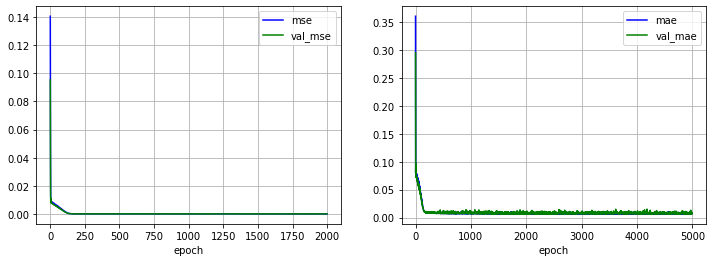

In [13]:
# Visualize error evolution
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(12,4))
hist.iloc[0:2000].plot(x='epoch', y=['mse','val_mse'],ax=ax1,marker="",color=['blue','green'])
plt.grid()
hist.iloc[0:30000].plot(x='epoch', y=['mae','val_mae'],ax=ax2,marker="",color=['blue','green'])
ax1.grid()
ax2.grid()
plt.show()

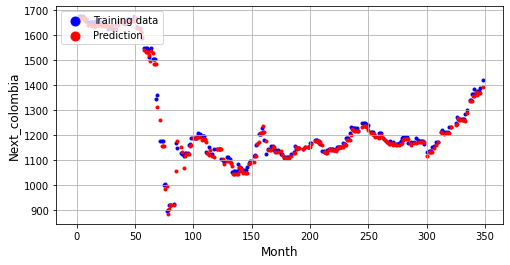

In [14]:
#6. Test the model vs trainning data and visualize
# Predict and de-scale.
Y_predict_train=model.predict(x_train)*Y_max
Y_train=y_train*Y_max

# Visualize next_colombia vs colombia on a timeline
fig=plt.figure(figsize=(8,4))
plt.ylabel('Next_colombia', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.scatter(train_time,Y_train, marker=".",color='blue')
plt.scatter(train_time,Y_predict_train,marker=".",color='red')
plt.legend(['Training data','Prediction'],loc="upper left",markerscale=3)
plt.grid()
plt.show()

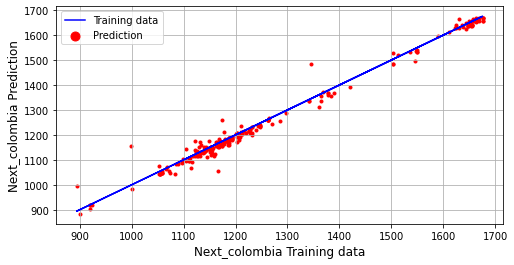

In [15]:
# Visualize Training results
fig=plt.figure(figsize=(8,4))
plt.ylabel('Next_colombia Prediction', fontsize=12)
plt.xlabel('Next_colombia Training data', fontsize=12)
plt.plot(Y_train,Y_train,color='blue')
plt.scatter(Y_train,Y_predict_train,marker=".",color='red')
plt.legend(['Training data','Prediction'],loc="upper left",markerscale=3)
plt.grid()
plt.show()

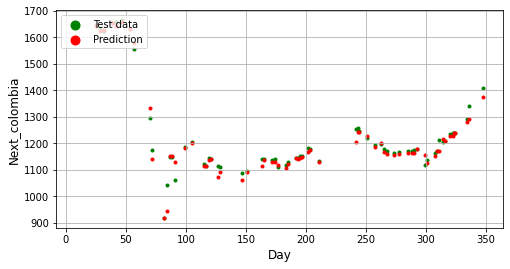

In [16]:
# Test the model vs test data, estimate error, and visualize
# Predict, de-scale, and round
Y_predict_test=model.predict(x_test)*Y_max
Y_predict_test=np.around(Y_predict_test.astype(np.float),2)
Y_test=y_test*Y_max
Y_test=np.around(Y_test.astype(np.float),2)

fig=plt.figure(figsize=(8,4))
plt.ylabel('Next_colombia', fontsize=12)
plt.xlabel('Day', fontsize=12)
plt.scatter(test_time,Y_test,marker=".",color='green')
plt.scatter(test_time,Y_predict_test,marker=".",color='red')
plt.legend(['Test data','Prediction'],loc="upper left",markerscale=3)
plt.grid()
plt.show()

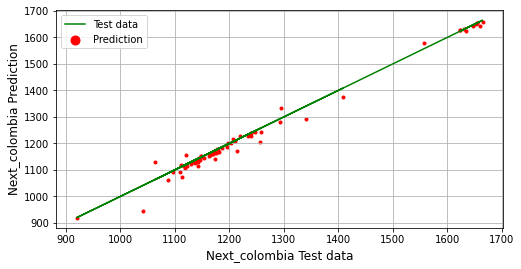

In [17]:
# Visualize test results
fig=plt.figure(figsize=(8,4))
plt.ylabel('Next_colombia Prediction', fontsize=12)
plt.xlabel('Next_colombia Test data', fontsize=12)
plt.plot(Y_test,Y_test,color='green')
plt.scatter(Y_test,Y_predict_test,marker=".",color='red')
plt.legend(['Test data','Prediction'],loc="upper left",markerscale=3)
plt.grid()
plt.show()

In [18]:
# Evaluate de model, and print the estimated model errors from testing
loss, val_mse, val_mae  = model.evaluate(x_test,y_test)

print('Test Data Mean Errors in COP:')
mae_COL= np.round(val_mae*Y_max,2)
print('Mean average error:', mae_COL)

mse_COL =np.round(val_mse*Y_max*Y_max,2)
print('Mean squared error:', mse_COL)

rmse_COL =np.round(np.sqrt(val_mse)*Y_max,2)
print('Root mean squared error:', rmse_COL)


70/70 [==============================] - 0s 71us/step
Test Data Mean Errors in COP:
Mean average error: 13.36
Mean squared error: 473.01
Root mean squared error: 21.75


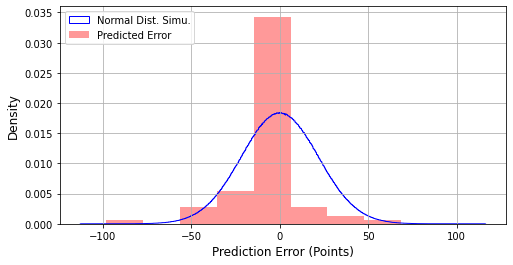

In [19]:
# Visualize the error distribution.
# Reshape labels for comparison

Y_test=Y_test.reshape(test_data_shape[0],1)
Y_predict_test=Y_predict_test.reshape(test_data_shape[0],1)
error=Y_predict_test-Y_test

# Plot Histogram
fig=plt.figure(figsize=(8,4))
plt.ylabel('Density', fontsize=12)
plt.xlabel('Prediction Error (Points)', fontsize=12)

plt.hist(error,bins=8, density=True, alpha=0.4,color='red')

data = np.random.randn(test_data_shape[0]*200000)*rmse_COL
plt.hist(data,bins=700,density=True,histtype='step',linewidth=1, color="blue");
plt.legend(['Normal Dist. Simu.','Predicted Error'],loc="upper left",markerscale=3)
plt.grid()
plt.show()
